In [5]:
import os, sys, pickle, time, re, csv, io, math
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import Lasso
from matplotlib.cm import ScalarMappable
from matplotlib import colors
from tqdm import tqdm


# Data structure



### Neuron npy files:
These contain the normalized firing rates of each neuron - spikes per frame (frame rate is 60 Hz)

npy files for each session
matrix with dimensions [neuron,trial,bin]

360 bins per trial, every state is 90 bins

### Location npy files:
These contain the location of the animal in each bin (should correspond exactly to the neuron bins)
locations1-9 are the 9 nodes

Then the remaining locations 10-21 are the bridges, coded in the "Edge_grid" array. just subtract 10 and that
gives you the index of the Edge_grid array which tells you which bridges are being referenced
e.g. an entry of 10 means index 0 which is array([1, 2]) (i.e. animal is at the the bridge between nodes 1 and 2)

### task_data
this is the task sequence used for that day (which nodes are rewarded in what order)


##Raw data:

Neuron_raw arrays are matrices of shape neurons X bins
each bin is the firing rate in a 25 ms timewindow

Location_raw arrays are arrays of length equal to the number of bins for the Neuron_raw matrix (may be 1 off)

trialtimes arrays are times (in ms) of each state: the first four columns are the start of each state
the fifth column is the end of the last state (D)

Pokes and Tone times in ms aligned to first trial - some will have negative timestamps if anumal poked before activating 
first A

Note that you'll have to convert the trial times, pokes and tone tomes from ms to bin number to subset the neuron 
and location arrays (i.e. divide by 25)

### Scores

A boolean matrix of N trials X N states (4) showing whether animal took shortest route between two 
reward locations or not (1 if shortest route taken; 0 if not)


### Analysis

Phase_state_place_anchoring a Nx4 boolean matrix (N= number of neurons) outlining results of tuning analysis: columns
aranged as follows: Phase, State, Place and Anchoring
e.g. a cell thats True, True, True, False is phase, state and place tuned but not spatially anchored
Phase and Place determined by beta values obtained from a GLM looking at tuning consistency across tasks
State boolean is determined by comparing peaks in mean firing in state space to those from shuffled data - a state cell
has significant peaks in atleast half of the tasks
Anchoring via relative rotation to possible anchors - an anchored cell has consiustent anchoring in atleast half of 
the tasks

All thresholds currently being refined



In [6]:
Data_folder= r'/Users/AdamHarris/Documents/PFC Subspaces/Data/'

In [7]:
def get_sessions(mouse_recday, Data_folder=Data_folder):
    
    Tasks = np.load(Data_folder + "Task_data_" + mouse_recday + ".npy")
    sessions_to_try = range(len(Tasks))
    sessions = []
    for session in sessions_to_try:
        try:
            data_neurons = np.load(
                Data_folder + "Neuron_" + mouse_recday + "_" + str(session) + ".npy"
            )
            sessions.append(session)
        except:
            print("Exception: " + mouse_recday + "_" + str(session) + ".npy  not found")
        
    return sessions, Tasks

def unroll_listoflists(l):
    flat_list = [item for sublist in l for item in sublist]
    return(flat_list)

def smooth_circ(xx, sigma=10, axis=0):
    x_smoothed = gaussian_filter1d(np.hstack((xx, xx, xx)), sigma, axis=axis)[
        len(xx) : int(len(xx) * 2)
    ]
    return x_smoothed

def mean_neuron_session(data_neuron):
    
    return np.mean(data_neuron, 0)

def std_err(data_neuron):
    return smooth_circ(sem(data_neuron, axis=0))

def occupency_map(raw_locs, maze_mat, place_plot):
    occupency_map = maze_mat.copy()
    for i in range(1,22):
        occupency_map[place_plot[i]]=np.sum(raw_locs==i)
        
    return occupency_map

def spikes_in_place_map(raw_spikes, raw_locs, maze_mat, place_plot):
    max_ind = min(len(raw_spikes), len(raw_locs))
    spikes_map=maze_mat.copy()
    raw_locs = raw_locs[:max_ind]
    raw_spikes = raw_spikes[:max_ind]
    for i in range(1,22):
        locs_ = raw_locs==i
        spikes_ = np.sum(raw_spikes[locs_])
        spikes_map[place_plot[i]] = spikes_
        
    return(spikes_map)

def place_map(raw_spikes, raw_locs, maze_mat, place_plot):
    occupency_ = occupency_map(raw_locs, maze_mat, place_plot)
    spikes_in_place_ = spikes_in_place_map(raw_spikes, raw_locs, maze_mat, place_plot)
    place_map = np.divide(spikes_in_place_, occupency_)
    return(place_map)
    

def get_raster_arrays(raw_spikes_state):
    spike_events_ = [np.where(raw_spikes_state[i]>0)[0] for i in range(len(raw_spikes_state))]
    trial_len_ = np.asarray([[len(raw_spikes_state[i])] for i in range(len(raw_spikes_state))])
    return spike_events_, trial_len_

def get_data_for_state(Neuron_raw, Location_raw, state, trial_times):

    Neuron_state = []
    Location_state = []
    Neuron_state_pertrial = []
    state_dic = {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3
    }
    
    for trial in trial_times:
        trial_inds = (trial/25).astype(int) # 25 is scaling factor between tria samling rate and neuron/locs sampling rate
        state_inds = [trial_inds[state_dic[state]], trial_inds[state_dic[state]+1]]

        neuron_ = Neuron_raw[state_inds[0]:state_inds[1]]
        locs_ = Location_raw[state_inds[0]:state_inds[1]]
        Neuron_state.extend(neuron_)
        Neuron_state_pertrial.append(neuron_)
        Location_state.extend(locs_)
        
    Neuron_state_arr = np.array(Neuron_state)
    Location_state_arr = np.array(Location_state)    
        
    return Neuron_state_arr, Location_state_arr, Neuron_state_pertrial


def get_max_time(raster, conversion=40):
    max_time=0
    for i in raster:
        if len(i)>0:
            if max(i)>max_time:
                max_time=max(i)
    bins = np.array(list(range(max_time)))
    bins_s = bins/conversion
    ind_of_max_s = 0
    max_s = 0
    for i , j in enumerate(bins_s):
        if i%conversion==0:
            ind_of_max_s  = i
            max_s = j.astype(int)
    return max_time/conversion, bins, ind_of_max_s, max_s

def average_over_factor(m, factor):
    # Calculate the number of columns in the reshaped array
    new_columns = m.shape[1] // factor * factor

    # Pad the array with zeros to make the number of columns divisible by the factor
    padded_m = np.pad(m[:, :new_columns], ((0, 0), (0, factor - (new_columns % factor))), mode='constant')

    # Reshape the array to have 'factor' columns per block and flatten the last dimension
    reshaped_m = padded_m.reshape(m.shape[0], -1, factor)

    # Take the mean along the last axis (axis=-1) to get the average for each block
    result = np.mean(reshaped_m, axis=-1)

    return result


def sample_every_nth(matrix, n):
    """
    Sample every nth element of a numpy matrix.

    Parameters:
    - matrix: numpy array, input matrix (1D or 2D)
    - n: int, sampling interval

    Returns:
    - numpy array, sampled elements
    """
    if matrix.ndim == 1:
        return matrix[::n]
    elif matrix.ndim == 2:
        return matrix[:, ::n]
    else:
        raise ValueError("Input matrix must be either 1 or 2-dimensional")

def average_over_factor_1d(arr, factor):
    # Calculate the number of elements in the reshaped array
    new_length = len(arr) // factor * factor

    # Pad the array with zeros to make the length divisible by the factor
    padded_arr = np.pad(arr[:new_length], (0, factor - (new_length % factor)), mode='constant')

    # Reshape the array to have 'factor' elements per block
    reshaped_arr = padded_arr.reshape(-1, factor)

    # Take the mean along the last axis (axis=-1) to get the average for each block
    result = np.mean(reshaped_arr, axis=-1)

    return result


def smooth_and_calculate_scalar_derivatives(data_matrix, sigma=3, dt=1.0):
    # Assuming data_matrix is an nx2 array with x and y positions

    # Separate x and y columns
    x_positions = data_matrix[:, 0]
    y_positions = data_matrix[:, 1]

    # Smooth the data using 1D Gaussian filter
    x_smoothed = gaussian_filter1d(x_positions, sigma=sigma)
    y_smoothed = gaussian_filter1d(y_positions, sigma=sigma)

    
    # Calculate speeds (first derivative) and magnitudes
    vx = np.gradient(x_smoothed, dt)
    vy = np.gradient(y_smoothed, dt)
    speed = np.sqrt(vx**2 + vy**2)

    # calculate acceleration
    acceleration = np.gradient(speed, dt)
    # Combine results into a single array
    smoothed_data = np.column_stack((x_smoothed, y_smoothed, speed, acceleration))

    return smoothed_data




In [8]:
Recording_days=np.load(Data_folder+'Recording_days_combined.npy')
Edge_grid=np.load(Data_folder+'Edge_grid.npy')

In [9]:
Recording_days

array(['ah03_18082021_19082021', 'ah04_01122021_02122021',
       'ah04_05122021_06122021', 'ah04_09122021_10122021',
       'me08_10092021_11092021', 'me10_09122021_10122021',
       'me11_01122021_02122021', 'me11_05122021_06122021'], dtype='<U22')

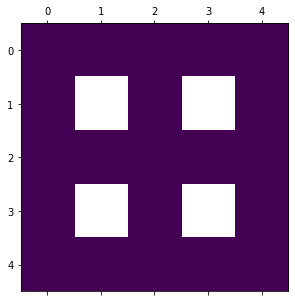

In [10]:
connections = [[0,1],
               [0,3],
               [1,4],
               [1,2],
               [2,5],
               [3,4],
               [3,6],
               [4,7],
               [4,5],
               [6,7],
               [7,8],
               [5,8]]


loc_mapping_for_plot = {
    1: (0,0),
    2: (0,2),
    3: (0,4),
    4: (2,0),
    5: (2,2),
    6: (2,4),
    7: (4,0),
    8: (4,2),
    9: (4,4),
    10: (0,1),
    11: (0,3),
    12: (1,0),
    13: (1,2),
    14: (1,4),
    15: (2,1),
    16: (2,3), 
    17: (3,0),
    18: (3,2),
    19: (3,4),
    20: (4,1),
    21: (4,3),
}
maze_mat = np.zeros((5,5))
maze_mat[1,1]=np.inf
maze_mat[1,3]=np.inf
maze_mat[3,1]=np.inf
maze_mat[3,3]=np.inf
plt.matshow(maze_mat)

In [11]:
Recording_days

array(['ah03_18082021_19082021', 'ah04_01122021_02122021',
       'ah04_05122021_06122021', 'ah04_09122021_10122021',
       'me08_10092021_11092021', 'me10_09122021_10122021',
       'me11_01122021_02122021', 'me11_05122021_06122021'], dtype='<U22')

In [12]:
mouse_recday = Recording_days[1]

sessions, Tasks = get_sessions(mouse_recday)

In [13]:
arr = np.array([1.0, 2.0, np.nan, 4.0, np.nan, 6.0])

# Create a boolean mask for NaN values
mask = np.isnan(arr)

# Use the mask to filter out NaN values
arr_without_nan = arr[~mask]

/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


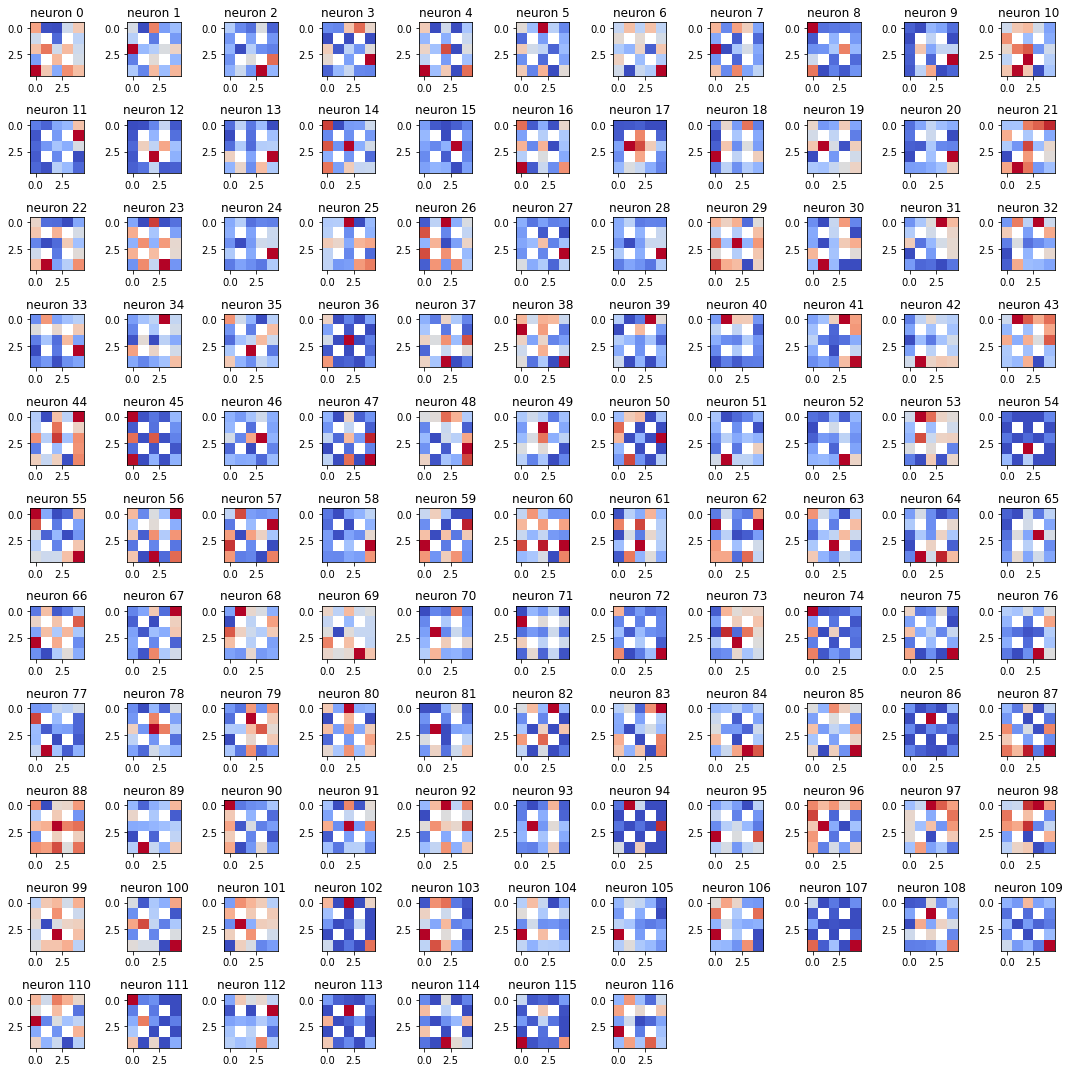

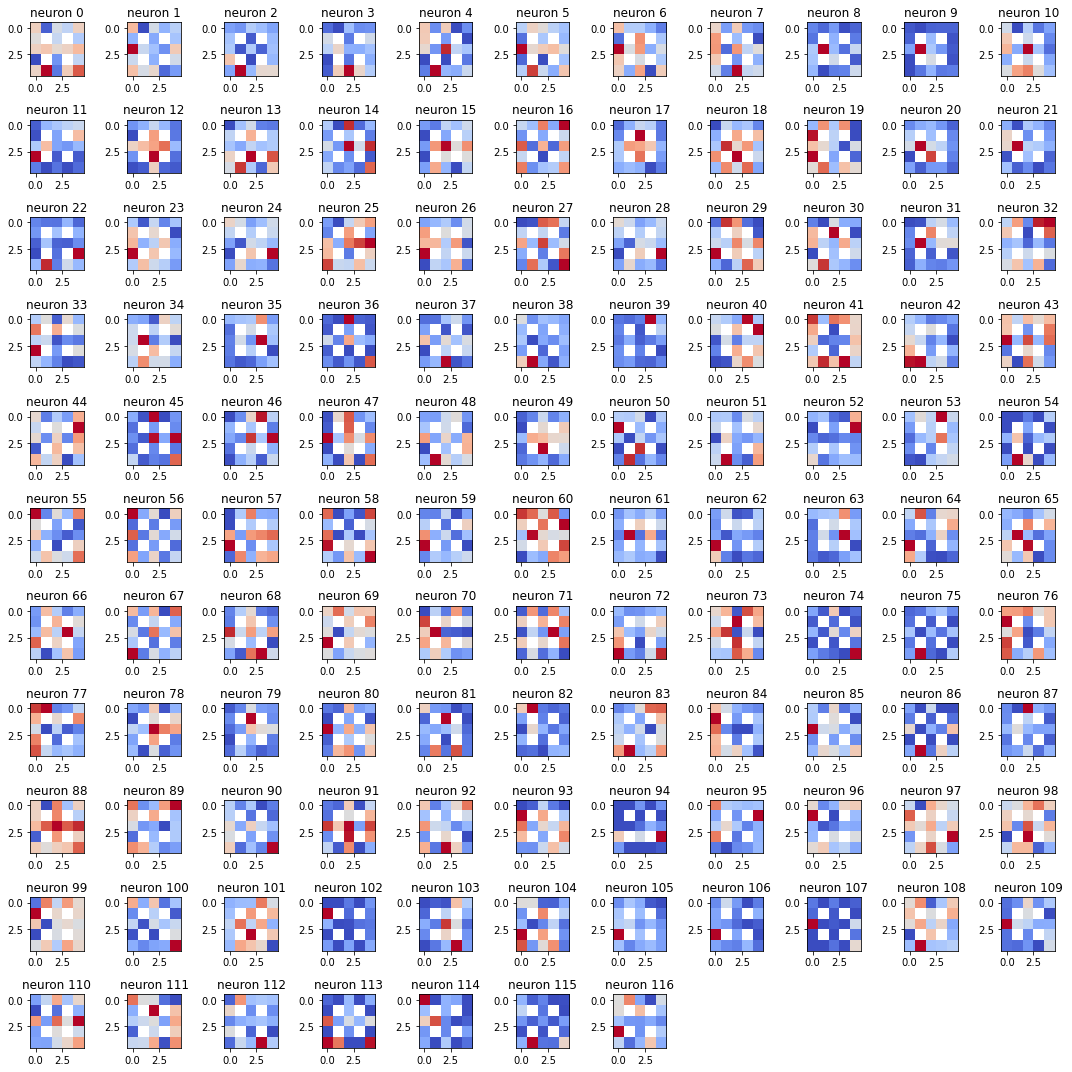

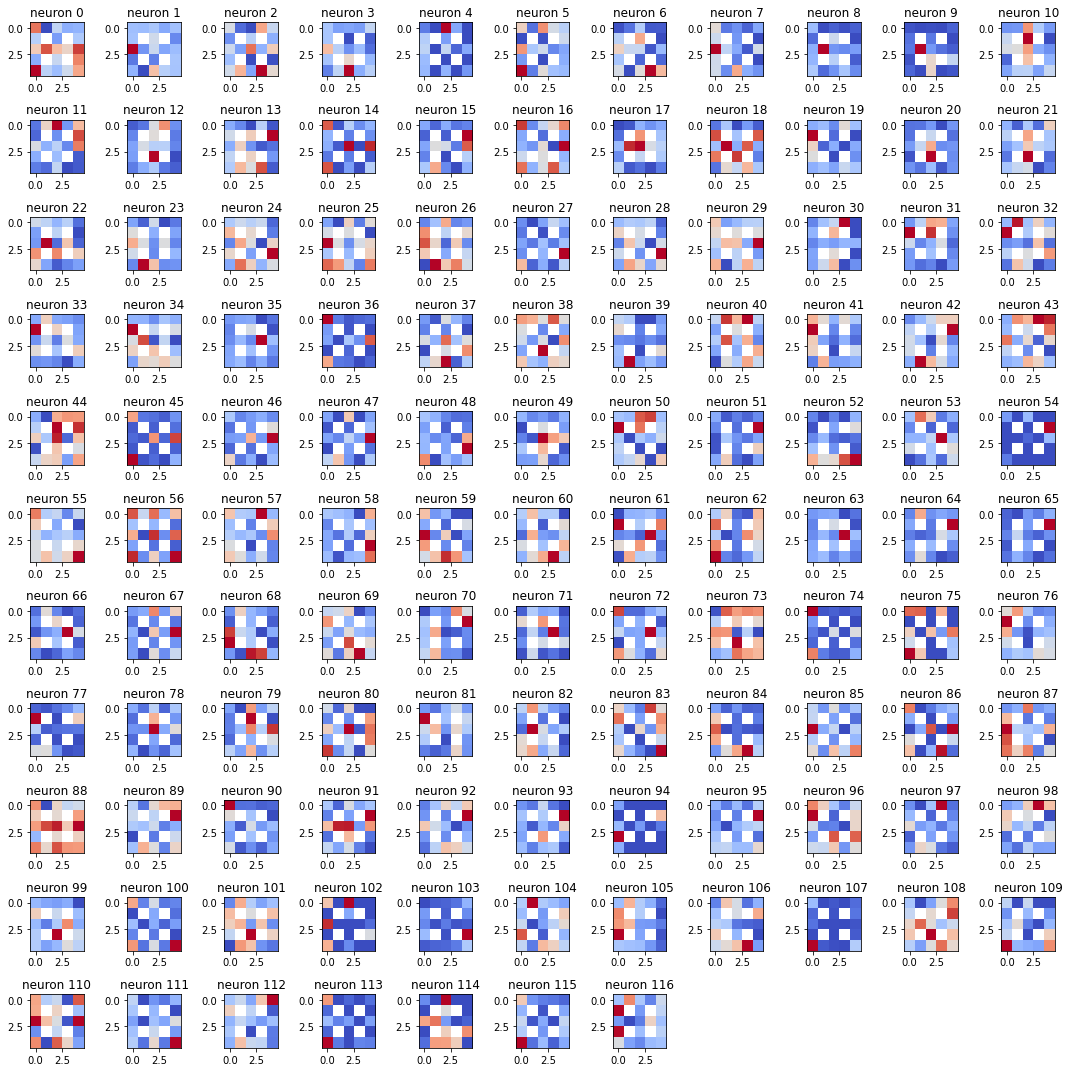

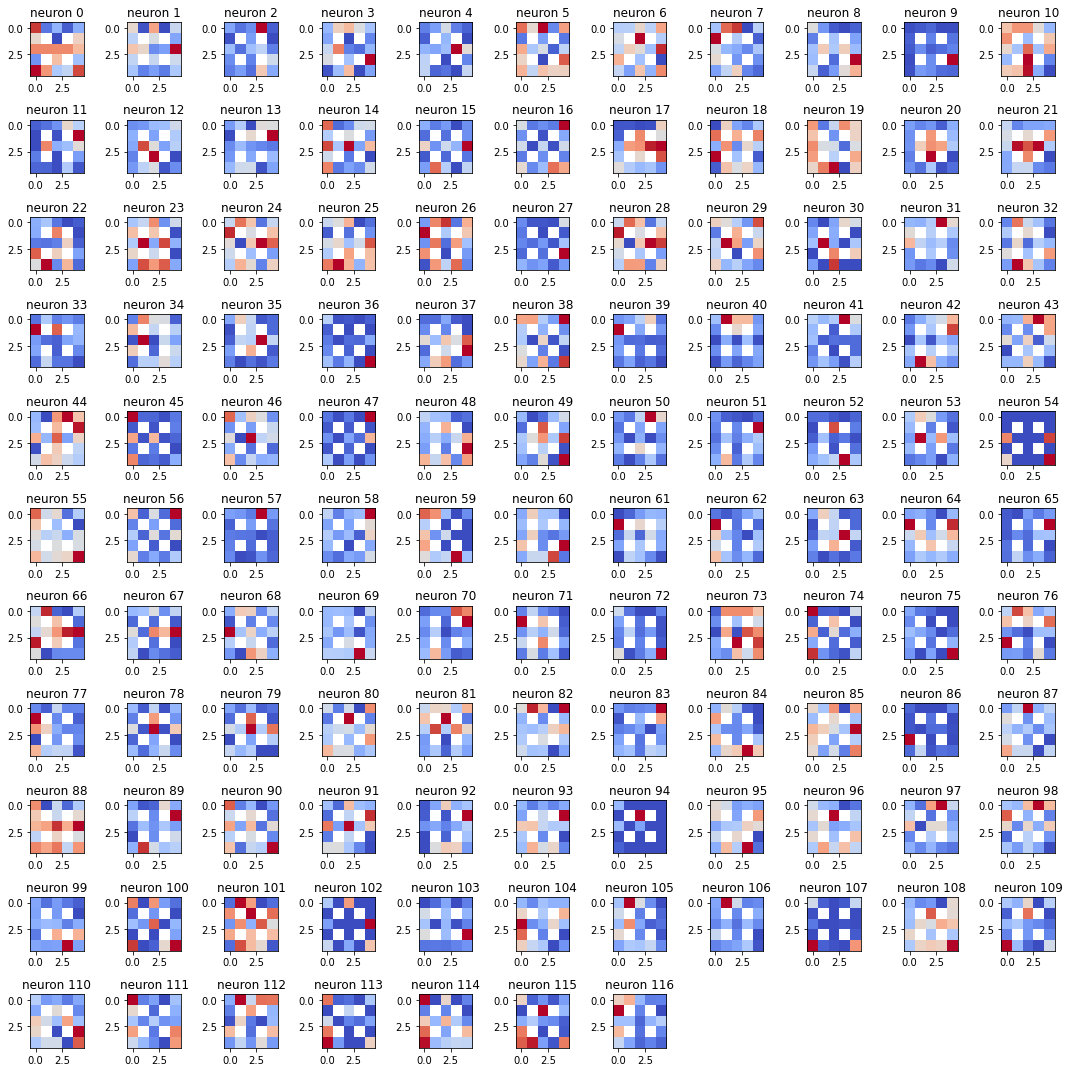

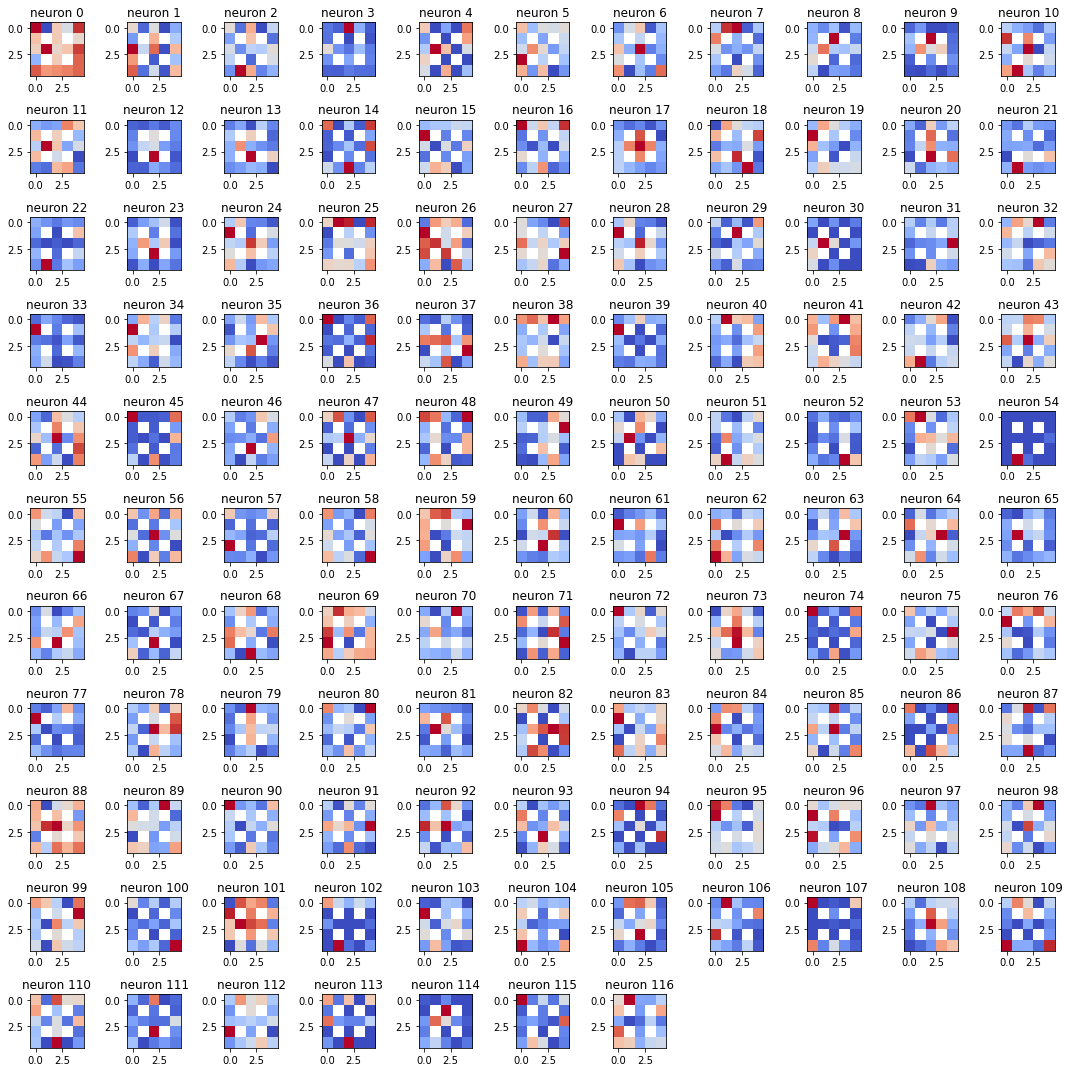

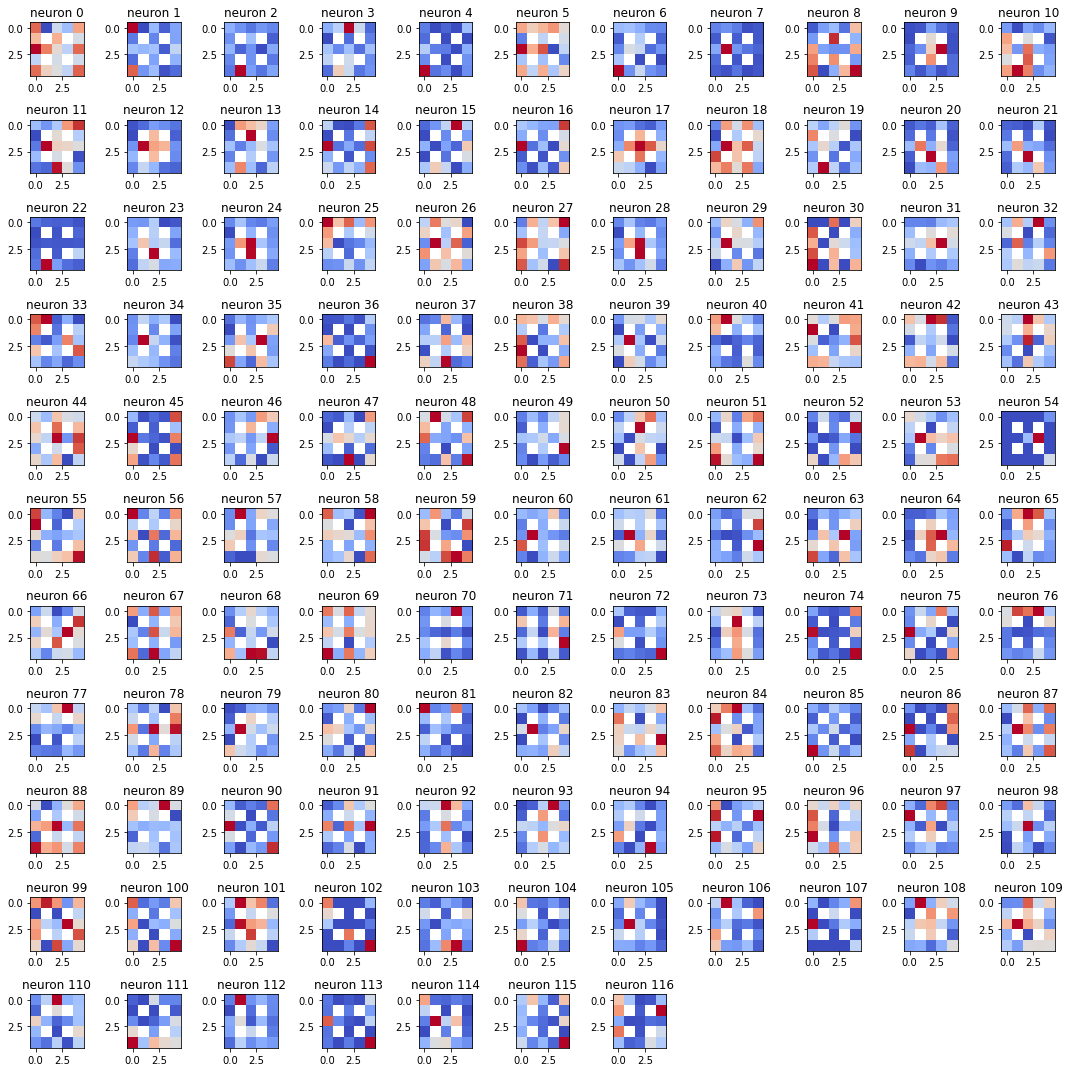

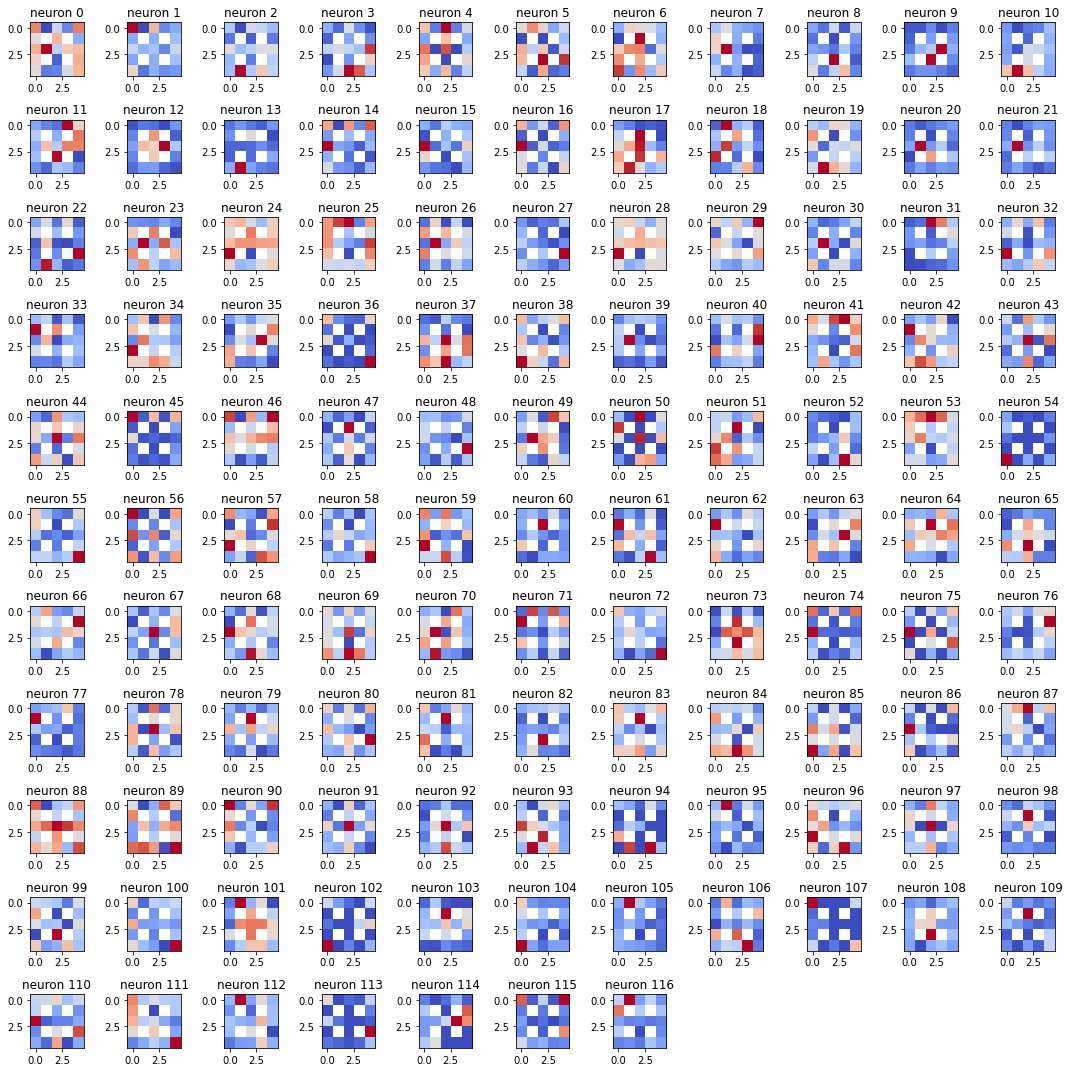

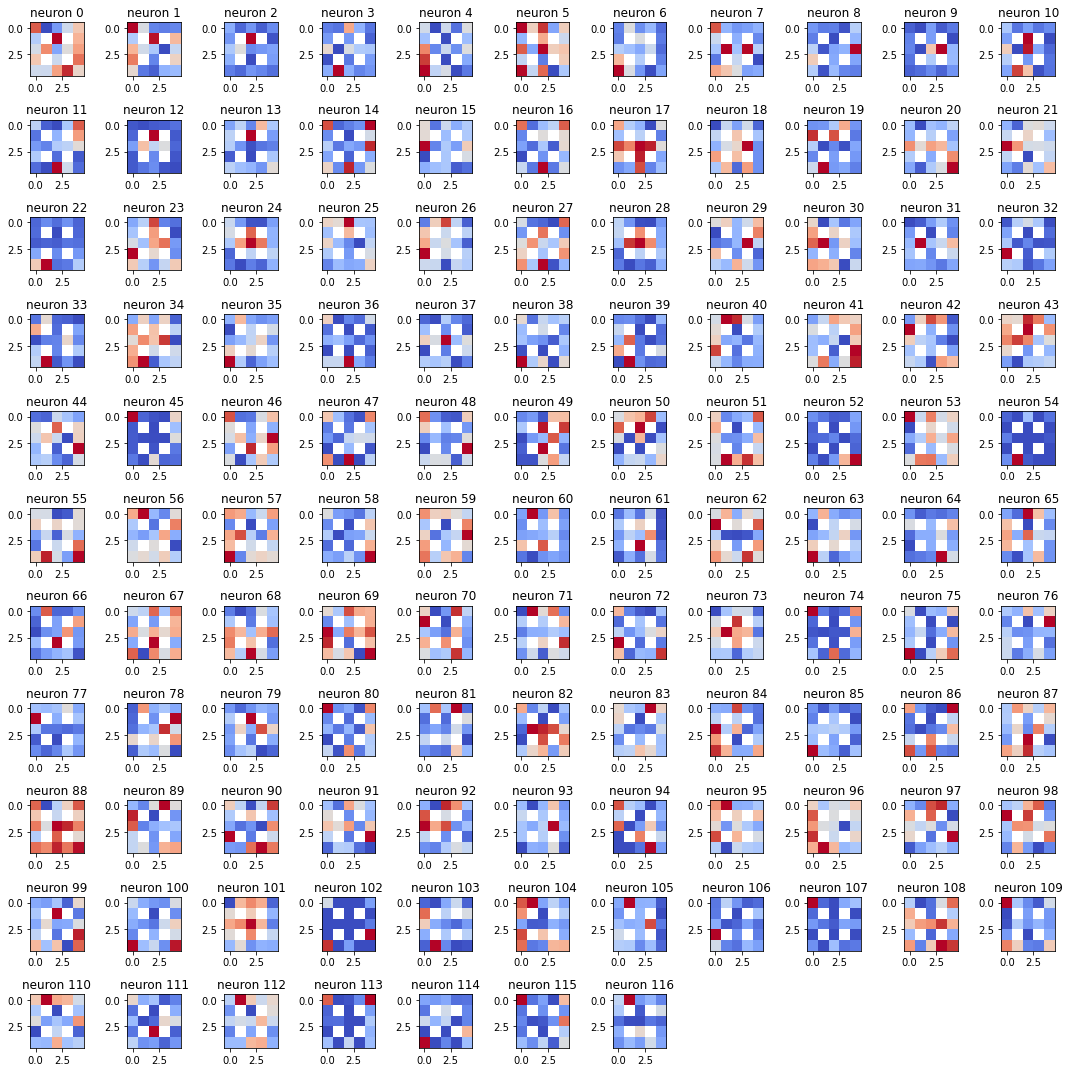

In [14]:
for counter, session in enumerate(sessions):
    
    task = Tasks[session]
    Neuron_raw=np.load(Data_folder+'Neuron_raw_'+mouse_recday+'_'+str(session)+'.npy')
    Location_raw=np.load(Data_folder+'Location_raw_'+mouse_recday+'_'+str(session)+'.npy')
    Trial_times=np.load(Data_folder+'trialtimes_'+mouse_recday+'_'+str(session)+'.npy')
    data_neurons=np.load(Data_folder+'Neuron_'+mouse_recday+'_'+str(session)+'.npy')
    
    num_neurons, num_trials = Neuron_raw.shape[0], Neuron_raw.shape[1]
    # Calculate the number of rows and columns for the subplot grid
    num_plots = num_neurons
    num_cols = int(np.ceil(np.sqrt(num_plots)))
    num_rows = int(np.ceil(num_plots / num_cols))

    # Create a subplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    # Flatten the axes array if necessary (depends on the number of rows and columns)
    axes = np.array(axes).flatten()
    pmaps_all = []
    # Plot each heatmap
    for neuron, ax in enumerate(axes[:num_plots]):
        pmap = place_map(Neuron_raw[neuron,:], Location_raw, maze_mat, loc_mapping_for_plot) 
        pmap_arr = np.array(pmap).flatten()
        mask = np.isnan(pmap_arr)
        pmap_nonan = pmap_arr[~mask]
        pmaps_all.append(pmap_nonan)
        ax.imshow(pmap, cmap='coolwarm', interpolation='nearest')
        entropy = st.entropy(pmap.flatten()[~np.isnan(pmap.flatten())])
        #ax.set_title(f'ent = {round(entropy, 2)}')
        ax.set_title(f'neuron {neuron}')
        
    pmaps_all = np.array(pmaps_all)

    # Hide any empty subplots
    for j in range(num_plots, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    fig.savefig(f'/Users/AdamHarris/Desktop/{mouse_recday}_session{session}_placemaps.svg')
    plt.close(fig)

In [15]:
def normalize_rows(arr):
    """
    Normalize the rows of a NumPy array to be between 0 and 1.
    
    Parameters:
    - arr: NumPy array
    
    Returns:
    - Normalized NumPy array
    """
    normalized_arr = (arr - arr.min(axis=1, keepdims=True)) / (arr.max(axis=1, keepdims=True) - arr.min(axis=1, keepdims=True))
    return normalized_arr
pmaps_all = normalize_rows(pmaps_all)


In [23]:


model = PCA()

W = model.fit_transform(pmaps_all.T)
H = model.components_

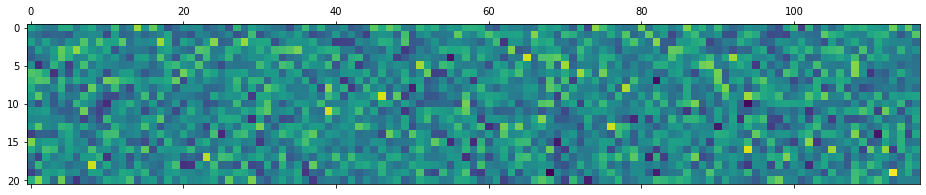

In [24]:
plt.matshow(H)
tr = model.transform(pmaps_all.T)




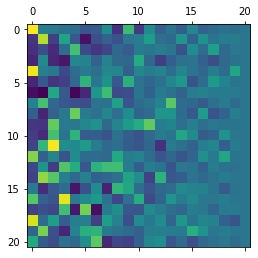

In [25]:
plt.matshow(W)

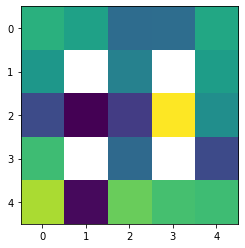

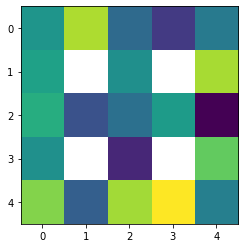

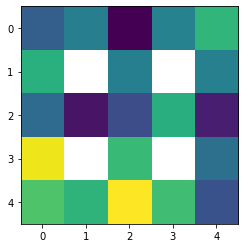

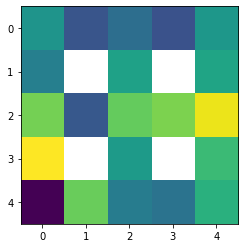

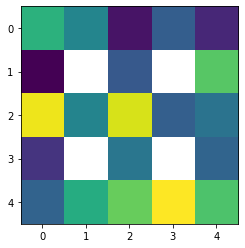

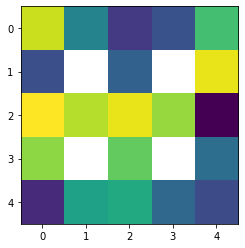

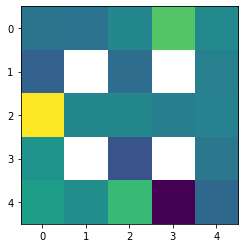

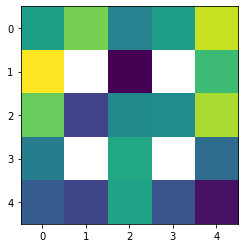

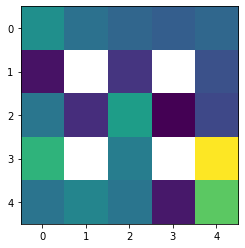

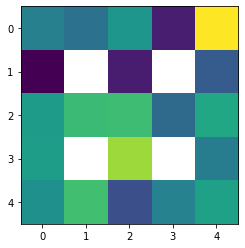

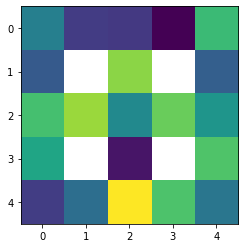

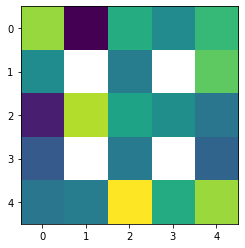

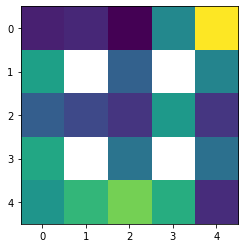

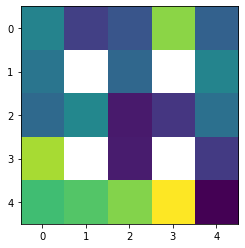

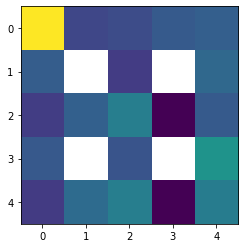

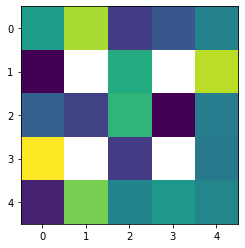

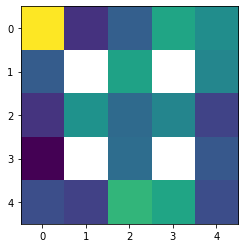

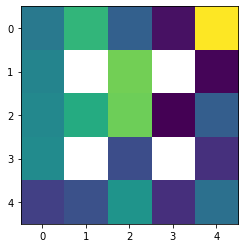

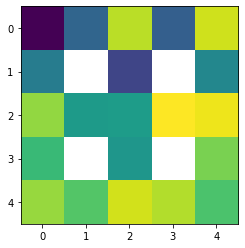

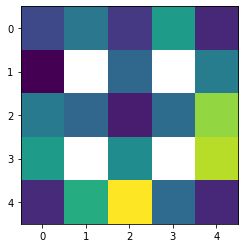

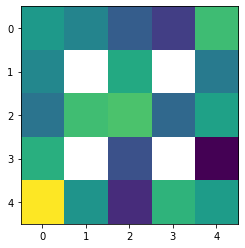

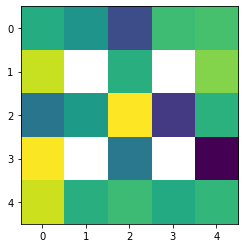

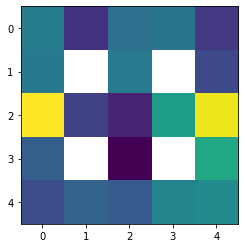

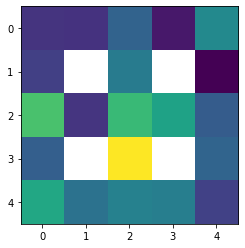

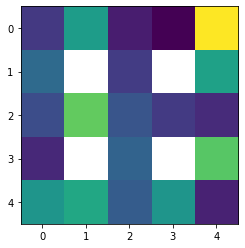

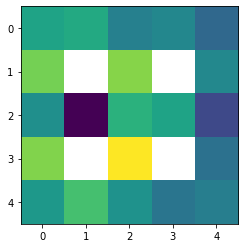

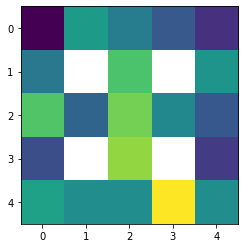

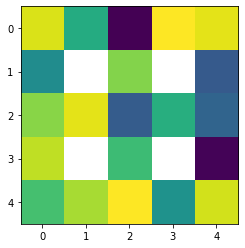

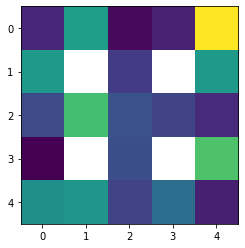

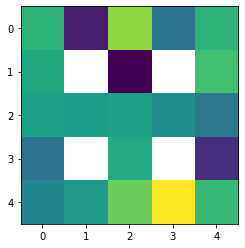

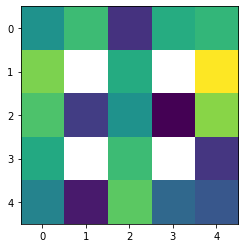

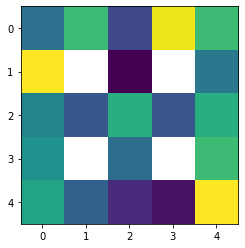

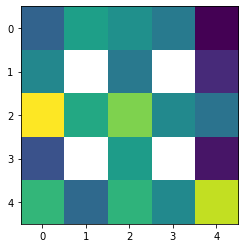

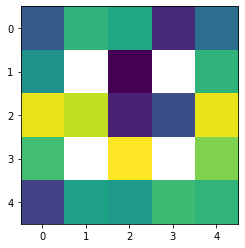

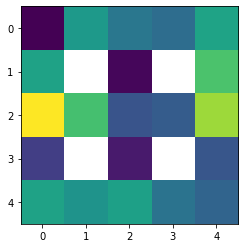

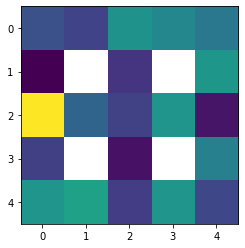

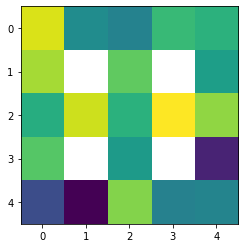

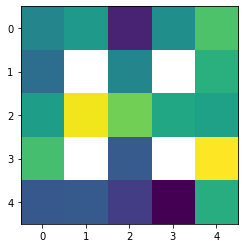

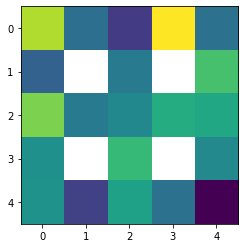

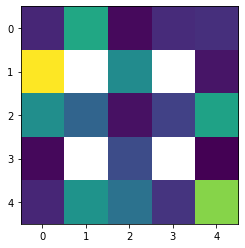

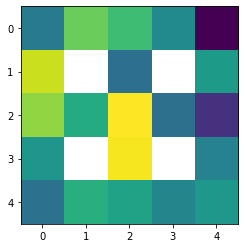

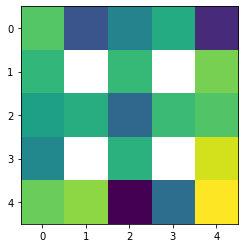

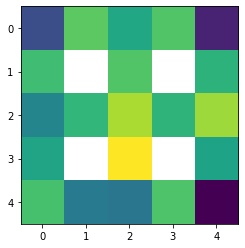

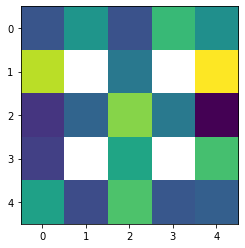

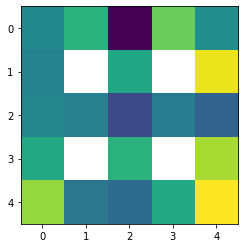

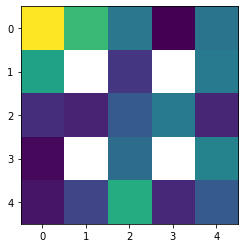

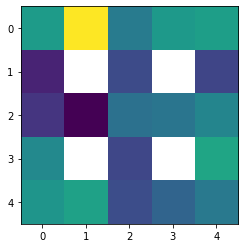

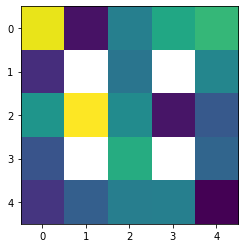

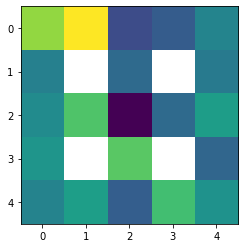

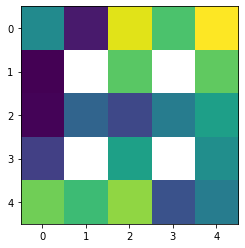

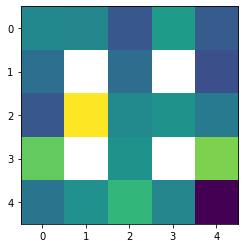

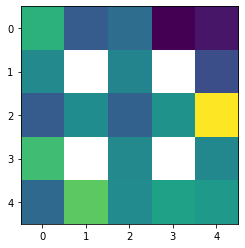

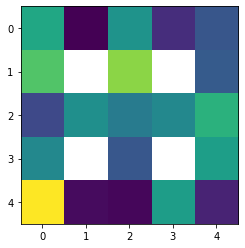

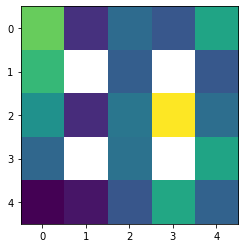

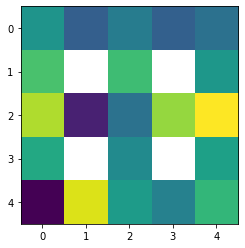

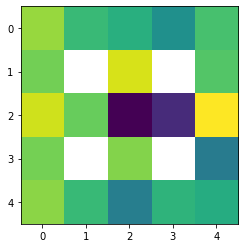

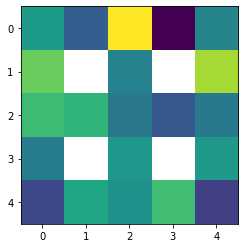

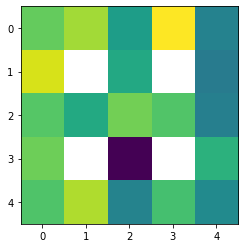

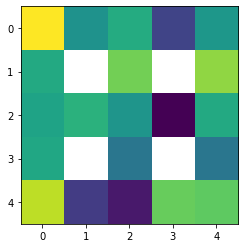

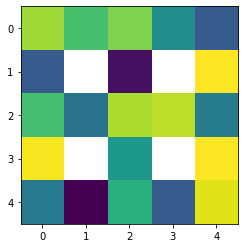

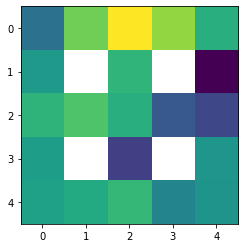

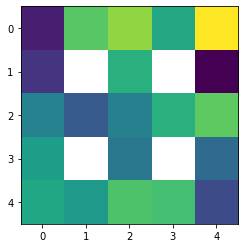

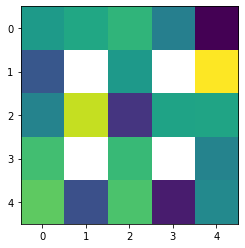

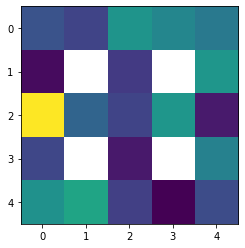

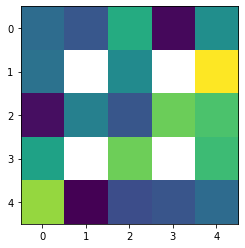

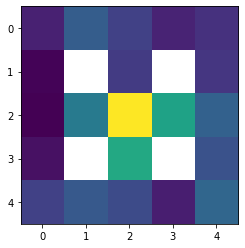

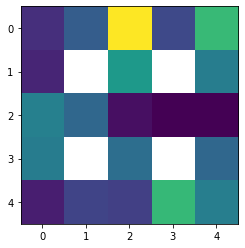

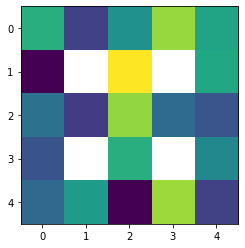

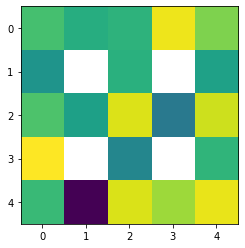

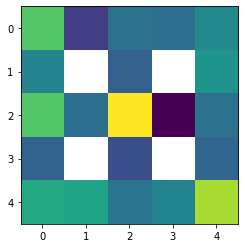

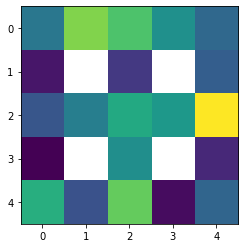

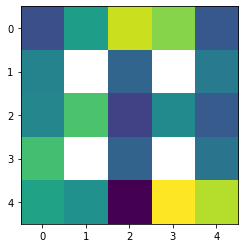

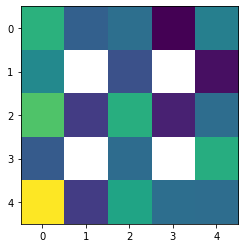

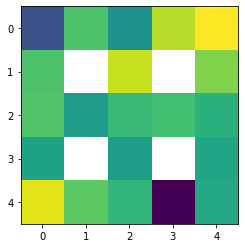

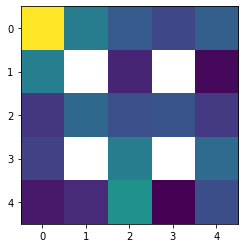

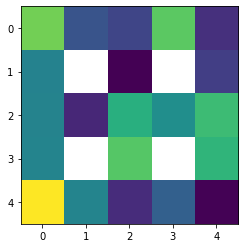

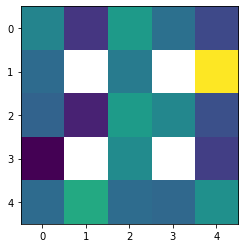

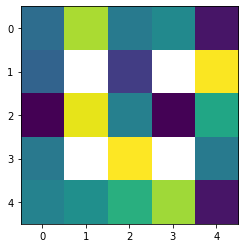

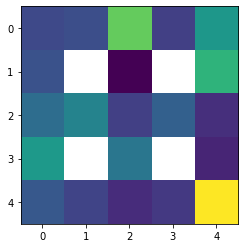

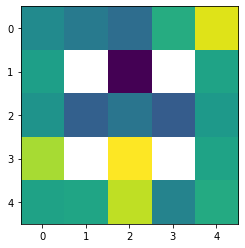

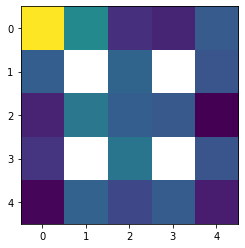

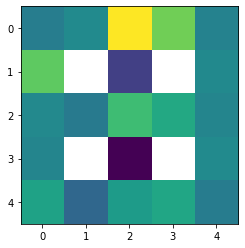

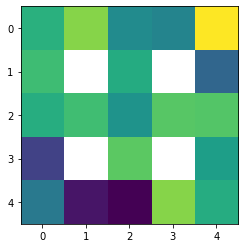

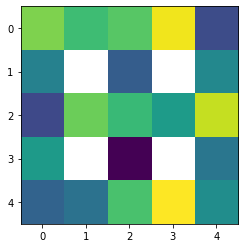

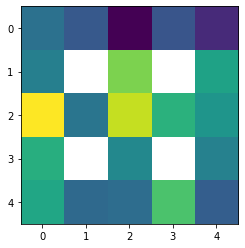

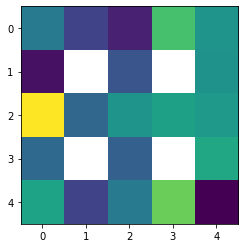

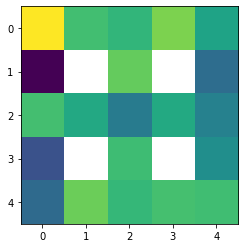

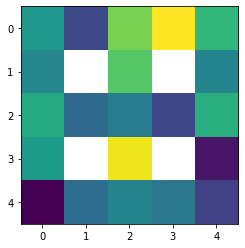

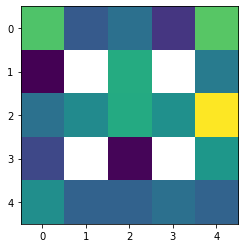

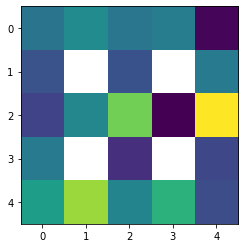

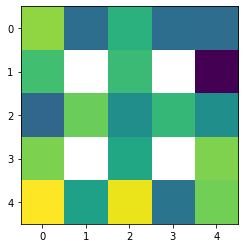

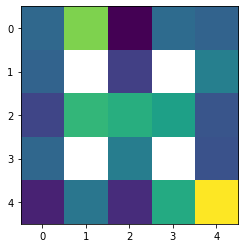

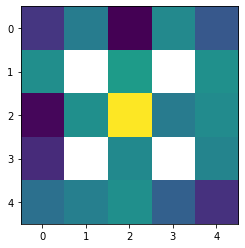

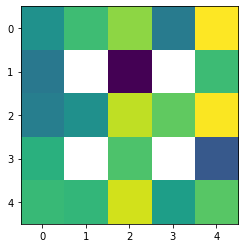

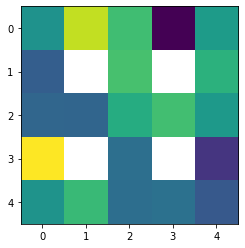

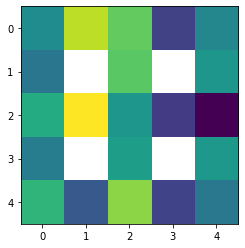

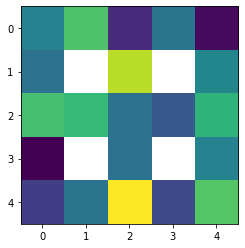

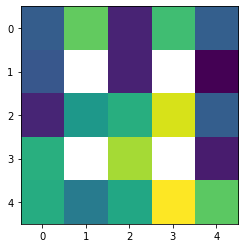

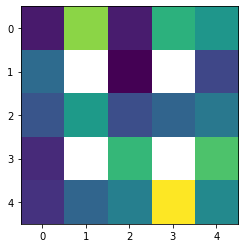

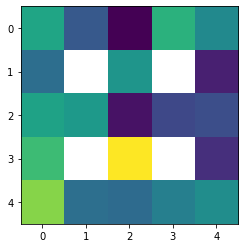

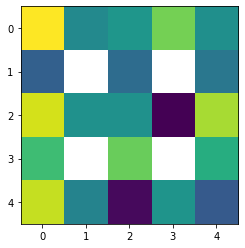

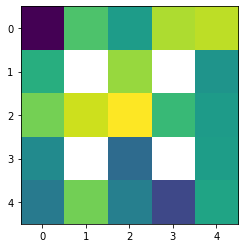

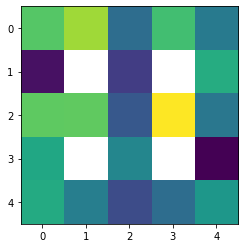

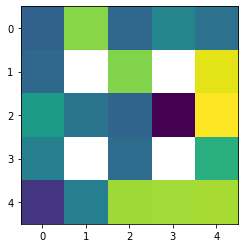

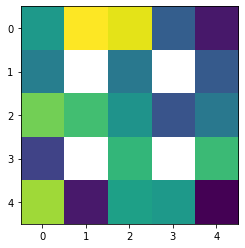

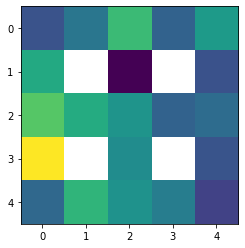

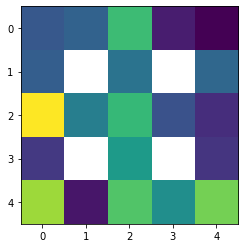

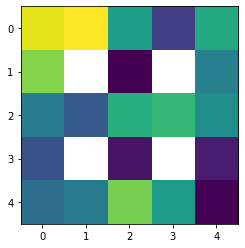

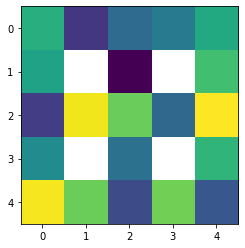

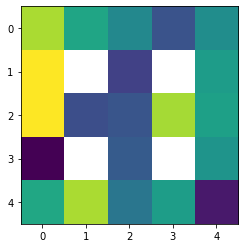

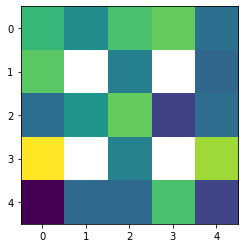

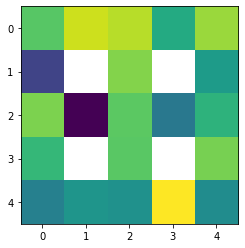

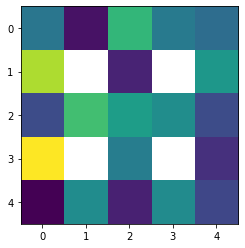

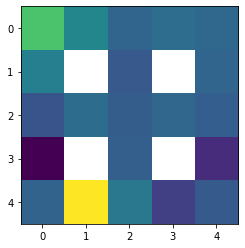

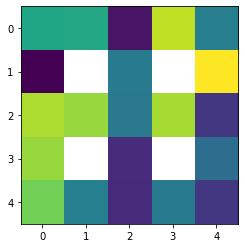

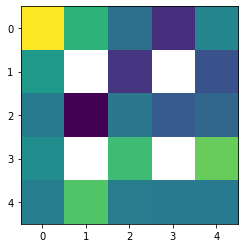

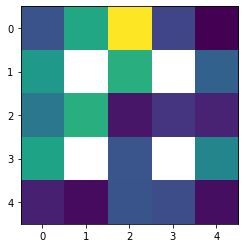

In [26]:
for i in H.T:
    map_frame =maze_mat.copy()
    for j, val in enumerate(i):
        map_frame[loc_mapping_for_plot[j+1][0], loc_mapping_for_plot[j+1][1]] = val
        
    plt.imshow(map_frame)
    plt.show()

In [27]:
Location_raw=np.load(Data_folder+'Location_raw_'+mouse_recday+'_'+str(session)+'.npy')
Trial_times=np.load(Data_folder+'trialtimes_'+mouse_recday+'_'+str(session)+'.npy')

In [28]:
Location_raw

array([6., 6., 6., ..., 6., 6., 6.])

In [29]:
subsetting = f'/Users/AdamHarris/Documents/PFC Subspaces/Data/Phase_state_place_anchored_{mouse_recday}.npy'
subsetting_array = np.load(subsetting)

spatial_cells = subsetting_array[:,2]
phase_cells = subsetting_array[:,0]
nophase_cells = ~phase_cells
nophase_state=np.logical_and(spatial_cells==True, phase_cells==False )

In [30]:
def cumulative_phase(arr):
    result = []
    current_value = arr[0]
    increment = 0
    
    for num in arr:
        if num == 2:
            increment += 1
            current_value = increment
        else:
            current_value = num + increment

        result.append(current_value)
    
    instance = 0
    current_val=0
    progress = []
    
    for num in result:

        if current_val == num:
            instance += 1
        else:
            current_val=num
            instance=1
        
        frames_in_phase = np.sum(np.array(result)==num)
        progress_through_phase =instance/frames_in_phase 
        progress.append(progress_through_phase)
        
    return result, np.array(progress)


def closest_match(input_float, float_array):
    closest_value = min(float_array, key=lambda x: abs(x - input_float))
    return closest_value


def get_lagged_location(locations, phases, num_lags=12, max_node=9):
    
    cum_phases, progress = cumulative_phase(phases)
    
    lagged_locations_mat = np.zeros((num_lags, len(locations)))
    
    for i, loc in enumerate(locations):
        current_phase = cum_phases[i]
        current_progress = progress[i]
        for lag in range(num_lags):
            if lag==0:
                lagged_locations_mat[lag, i]=loc
                
            elif current_phase-lag < 0:
                pass
                
            else:
                lagged_phase = current_phase-lag
                mask_ = np.array(cum_phases)==lagged_phase
                lagged_progress_arr = np.array(progress[mask_])
                lagged_locs = locations[mask_]
                lagged_progress_guess = closest_match(current_progress, lagged_progress_arr)
                

                lagged_location = lagged_locs[lagged_progress_arr==lagged_progress_guess]
                if lagged_location>max_node:
                    lagged_location=0
                lagged_locations_mat[lag, i]=lagged_location

    return lagged_locations_mat 

In [31]:
xxx=np.array([0,1,2,3,4,5,6,7,8])
xxx=np.tile(xxx,10)
yyy = np.repeat(np.array([0,1,2]), 3)
yyy = np.tile(yyy, 10)

lg = get_lagged_location(xxx, yyy)


In [32]:
print(lg)

[[0. 1. 2. ... 6. 7. 8.]
 [0. 0. 0. ... 2. 6. 7.]
 [0. 0. 0. ... 7. 2. 6.]
 ...
 [0. 0. 0. ... 6. 7. 2.]
 [0. 0. 0. ... 2. 6. 7.]
 [0. 0. 0. ... 7. 2. 6.]]


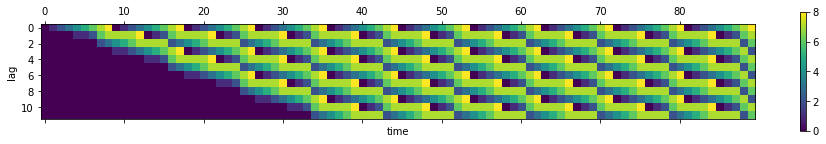

In [33]:

plt.matshow(lg)
plt.xlabel('time')
plt.ylabel('lag')
plt.colorbar()

In [34]:


# # Example usage:
# input_array = [0, 0,0,0,0,0, 1,1,1,1,1,1, 1, 2, 2, 2, 0,0,0, 0, 1,1,1,1, 1,2,2,2,2,0,0,0,1,1,1]
# output_array, x = convert_array(input_array)
# print(output_array)
# print(x)

In [35]:
# sessions, Tasks = get_sessions(mouse_recday)
phase_partitions = 3
downsample_factor=5
speed_threshold = 5
acceleration_threshold = 0
phase_type = 'distance'   #distance or time
conf_group='none'   # speed+ speed-  acceleration+  acceleraion -

for counter, session in enumerate(sessions):
    
    task = Tasks[session]
    
    Neuron_raw=np.load(Data_folder+'Neuron_raw_'+mouse_recday+'_'+str(session)+'.npy')
    Location_raw=np.load(Data_folder+'Location_raw_'+mouse_recday+'_'+str(session)+'.npy')
    
    XY_raw = np.load(Data_folder+'XY_raw_'+mouse_recday+'_'+str(session)+'.npy')
    XY_processed = smooth_and_calculate_scalar_derivatives(XY_raw, sigma=5)
    speed = XY_processed[:,2]
    acceleration = XY_processed[:,3]

    Trial_times=np.load(Data_folder+'trialtimes_'+mouse_recday+'_'+str(session)+'.npy')
    #data_neurons=np.load(Data_folder+'Neuron_'+mouse_recday+'_'+str(session)+'.npy')
    
    # downsample neurons and locations
    Neuron_raw_downsampled=average_over_factor(Neuron_raw, downsample_factor)
    Location_raw_downsampled=sample_every_nth(Location_raw, downsample_factor)
    speed_downsampled = average_over_factor_1d(speed, downsample_factor)
    acceleration_downsampled = average_over_factor_1d(acceleration, downsample_factor)
    #use trial_times to get phase labels
    Trial_times_sr_adj = (Trial_times/25).astype(int)
    
    
    for trial_num, trial in enumerate(Trial_times_sr_adj):
        for state, _ in enumerate(trial[:-1]):
            
            state_length = trial[state+1]-trial[state]
            
            if phase_type=='time':
                phase_length = math.floor(state_length/phase_partitions)

                if phase_partitions==3:
                    phase_state = np.hstack((np.repeat(0, phase_length), 
                                            np.repeat(1, phase_length),
                                            np.repeat(2, phase_length)))
                if phase_partitions ==5:
                    phase_state = np.hstack((np.repeat(0, phase_length), 
                                            np.repeat(1, phase_length),
                                            np.repeat(2, phase_length),
                                            np.repeat(3, phase_length),
                                            np.repeat(4, phase_length)))
                
                error=state_length-phase_partitions*phase_length
                error_add_on = np.repeat(phase_partitions-1, error)
                phase_state=np.hstack((phase_state, error_add_on))
                
                
            if phase_type=='distance':
                
                movements_state = speed[trial[state]:trial[state+1]]
                cumulative_distance = np.cumsum(movements_state)
                max_distance = cumulative_distance[-1]
                distance_proportion = cumulative_distance/max_distance
                phase_dist_ = math.floor(1/phase_partitions)
                phase_thresholds = np.linspace(0, 1, num=phase_partitions+1, endpoint=True)
                phase_state = np.digitize(distance_proportion, phase_thresholds, right=True)
                phase_state = phase_state-1

            
            if state==0:
                phase_trial = phase_state
            else:
                phase_trial = np.hstack((phase_trial, phase_state))

        if trial_num==0:
            phase_session = phase_trial
        else:
            phase_session = np.hstack((phase_session, phase_trial))        
            
#             for phase_discrete in range(phase_partitions):
#                 if phase_discrete+1==phase_partitions:
#                     phase_arr_[-phase_length:]=phase_discrete #used this to catch any bins left out by rounding errors
#                 else:
#                     phase_arr_[phase_discrete*phase_length:phase_discrete+1*phase_length]
            
#             if trial_num==0:
#                 phase_array_full_sess=phase_arr_
#             else:
#                 phase_array_full_sess=np.hstack((phase_array_full_sess, phase_arr_))
        
    
    Phase_raw_downsampled=sample_every_nth(phase_session, downsample_factor)
    print('_____________________________________')
    print(f'Bin_counts: neurons {Neuron_raw_downsampled.shape[1]}, \n'
            f'loctions {len(Location_raw_downsampled)}, \n'
            f'phases {len(Phase_raw_downsampled)}')
            
    min_ind = min(Neuron_raw_downsampled.shape[1], len(Location_raw_downsampled), len(Phase_raw_downsampled))
    
    
    Neuron_raw_downsampled = Neuron_raw_downsampled[:,:min_ind]
    Location_raw_downsampled = Location_raw_downsampled[:min_ind]
    Phase_raw_downsampled = Phase_raw_downsampled[:min_ind]
    
    lagged_locations = get_lagged_location(Location_raw_downsampled, Phase_raw_downsampled,num_lags=13)
    
    mask=Location_raw_downsampled<10
    
    Phase_downsampled_nodes_only = Phase_raw_downsampled[mask]
    Location_downsampled_nodes_only = Location_raw_downsampled[mask]
    Neuron_downsampled_nodes_only = Neuron_raw_downsampled[:,mask]
    Lagged_locations_nodes_only = lagged_locations[:,mask]
    print('-  -  -  -  -  -  -  -  -  -  -  -  - ')
    
    print('Removed bins where animal is on edge not node')
    
    print(f'Bin_counts: neurons {Neuron_downsampled_nodes_only.shape[1]}, \n'
            f'loctions {len(Location_downsampled_nodes_only)}, \n'
            f'phases {len(Phase_downsampled_nodes_only)}')
    print(f'lag dims  {Lagged_locations_nodes_only.shape[1]}')
   
    
    #initialise data arrays
    if counter == 0:
        Neuron_array = Neuron_downsampled_nodes_only
        Location_array = Location_downsampled_nodes_only
        Phase_array = Phase_downsampled_nodes_only
        Lags_array = Lagged_locations_nodes_only
    else:
        Neuron_array = np.hstack((Neuron_array, Neuron_downsampled_nodes_only))
        Location_array = np.hstack((Location_array, Location_downsampled_nodes_only)).astype(int)
        Phase_array = np.hstack((Phase_array, Phase_downsampled_nodes_only))
        Lags_array = np.hstack((Lags_array, Lagged_locations_nodes_only))

_____________________________________
Bin_counts: neurons 6889, 
loctions 6889, 
phases 6889
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 5781, 
loctions 5781, 
phases 5781
lag dims  5781
_____________________________________
Bin_counts: neurons 9222, 
loctions 9221, 
phases 9221
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 7636, 
loctions 7636, 
phases 7636
lag dims  7636
_____________________________________
Bin_counts: neurons 9093, 
loctions 9093, 
phases 9092
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 7616, 
loctions 7616, 
phases 7616
lag dims  7616
_____________________________________
Bin_counts: neurons 9156, 
loctions 9155, 
phases 9155
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 7584, 
loctions 7584, 
phases 7584
lag dims  7584
________

In [52]:
len(Phase_array)


57130

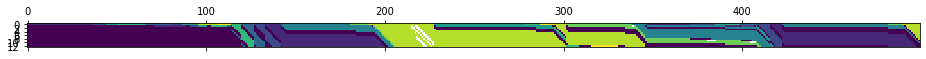

In [36]:
plt.matshow(Lags_array[:,:500])

In [37]:
print(Lags_array[:,100:20])

[]


In [38]:

one_hot_all = []

for i in tqdm(range(Lags_array.shape[1])):

    timepoint_lags = Lags_array[:,i]
    one_hot = np.zeros((len(timepoint_lags), max(Lags_array[0,:].astype(int))))
    
    for lag, node in enumerate(timepoint_lags):
        node=node.astype(int)
        if node<1:
            pass
        else:
            one_hot[lag,node-1]=1
    one_hot_all.append(one_hot.flatten())
    
one_hot_all = np.array(one_hot_all)

100%|██████████| 57130/57130 [03:05<00:00, 308.72it/s]


In [50]:
NUM_ITERS = 50
NUM_NEURONS = Neuron_array.shape[0]
NUM_REGRESSORS = np.array(one_hot_all).shape[1]
LASSO_PARAM = 0.00005

for iteration in tqdm(range(NUM_ITERS)):
    
    split_1_mask = np.random.choice([0, 1], size=(Lags_array.shape[1],), p=[0.5, 0.5]).astype(bool)
    split_2_mask = ~split_1_mask
    
    betas_array_1 = np.zeros((NUM_NEURONS, NUM_REGRESSORS))
    betas_array_2 = np.zeros((NUM_NEURONS, NUM_REGRESSORS))
    
    for neuron, activity_array in enumerate(Neuron_array):
        
        activity_array_split_1 = activity_array[split_1_mask]
        activity_array_split_2 = activity_array[split_2_mask]
        
        one_hot_all_split_1 = one_hot_all[split_1_mask, :]
        one_hot_all_split_2 = one_hot_all[split_2_mask, :]
        
        lasso_1 = Lasso(alpha = LASSO_PARAM)
        lasso_1.fit(one_hot_all_split_1, activity_array_split_1)
        betas_1 = lasso_1.coef_
        
        lasso_2 = Lasso(alpha = LASSO_PARAM)
        lasso_2.fit(one_hot_all_split_2, activity_array_split_2)
        betas_2 = lasso_2.coef_
        
        betas_array_1[neuron,:]=betas_1
        betas_array_2[neuron,:]=betas_2
        
        
    if iteration==0:
        stacked_betas = np.stack((betas_array_1, betas_array_2))
    else:
        stacked_betas = np.concatenate((stacked_betas, np.expand_dims(betas_array_1, axis=0)), axis=0)
        stacked_betas = np.concatenate((stacked_betas, np.expand_dims(betas_array_2, axis=0)), axis=0)
        
        
num_stacks_in_split = math.floor(stacked_betas.shape[0]/2)

stack_split_1 = stacked_betas[:num_stacks_in_split,:,:]
stack_split_2 = stacked_betas[num_stacks_in_split:,:,:]

mean_betas_1 = np.nanmean(stack_split_1, axis=0)
mean_betas_2 = np.nanmean(stack_split_2, axis=0)


row_means_1 = np.mean(mean_betas_1, axis=1, keepdims=True)
row_means_2 = np.mean(mean_betas_2, axis=1, keepdims=True)

centred_betas_1 = mean_betas_1 - row_means_1
centred_betas_2 = mean_betas_2 - row_means_2
        

  0%|          | 0/50 [00:00<?, ?it/s]


IndexError: boolean index did not match indexed array along dimension 1; dimension is 117 but corresponding boolean dimension is 57130

In [40]:
stack_split_1[0]

array([[ 0.03103558, -0.0706445 , -0.08425724, ..., -0.02622387,
         0.06241721,  0.01118446],
       [ 0.01433482,  0.        , -0.0159152 , ..., -0.00090252,
         0.        ,  0.        ],
       [-0.        , -0.00454355, -0.01022099, ..., -0.        ,
         0.        , -0.00225907],
       ...,
       [ 0.00044929, -0.        , -0.00242703, ..., -0.        ,
         0.        ,  0.        ],
       [ 0.02997854, -0.0168828 ,  0.00687963, ...,  0.01471779,
        -0.01281226, -0.01951985],
       [ 0.05063303, -0.        ,  0.00243892, ..., -0.00433984,
        -0.00902862,  0.        ]])

In [41]:
# fig, axs = plt.subplots(figsize = (10,5))
# plt.suptitle('Regression betas for each split')
# axs.matshow(centred_betas_1[:50,:27], cmap='bwr')
# axs.set_xlabel('lag-location conjunction')
# axs.set_ylabel('Neuron')
# for bound in range(3):
    
#     axs.axvline(9*bound-0.5, color='b')
# plt.tight_layout()
# fig.savefig('/Users/AdamHarris/Desktop/task_lag_betas.svg')

In [42]:


# plt.matshow(centred_betas_1[:50,:27], cmap='bwr')
# plt.title('Regression betas for each split')
# plt.colorbar()
# plt.savefig('/Users/AdamHarris/Desktop/task_lag_betas_CB.svg')


In [43]:
degrees = [2,3,2,3,4,3,2,3,2]
colors_for_annotation = ['black','black','black','black','white','black','black','black','black']

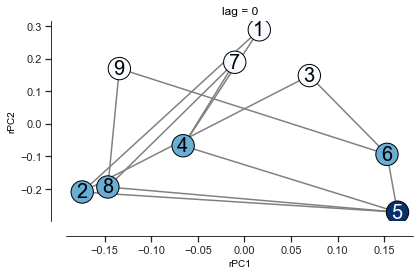

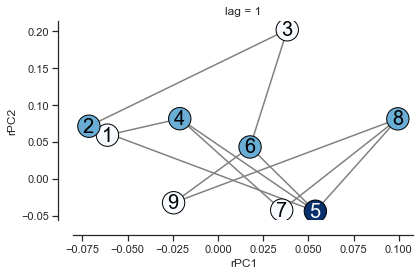

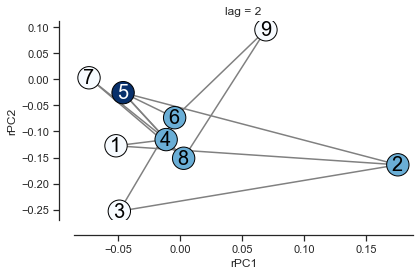

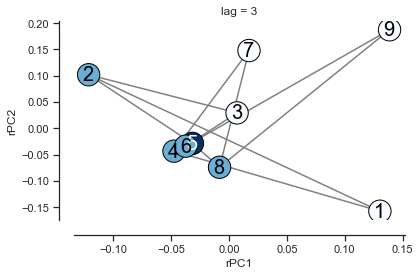

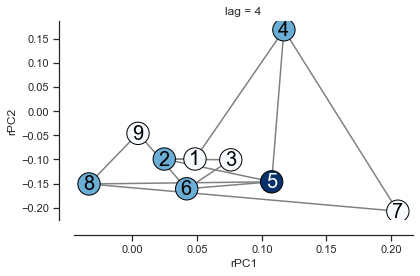

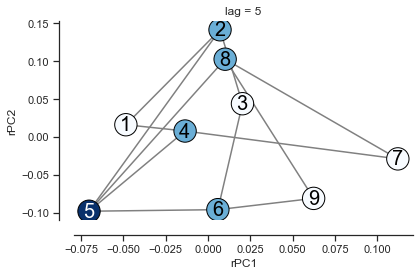

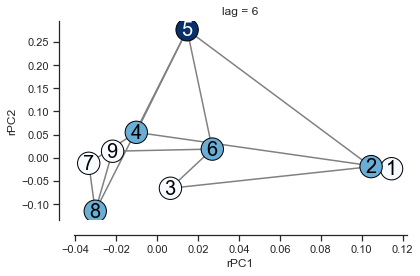

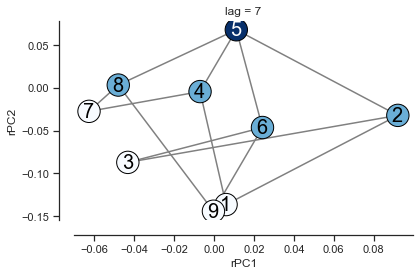

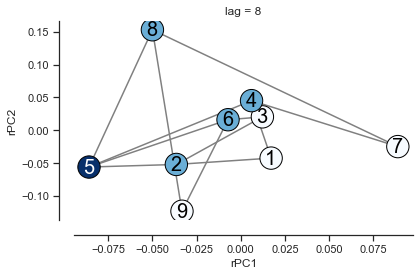

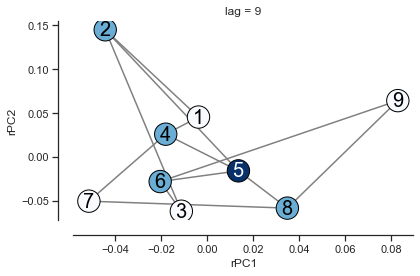

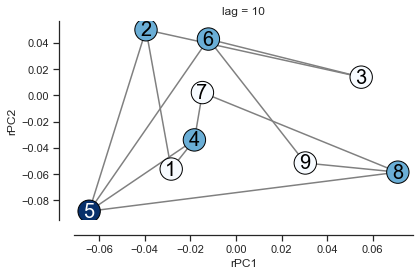

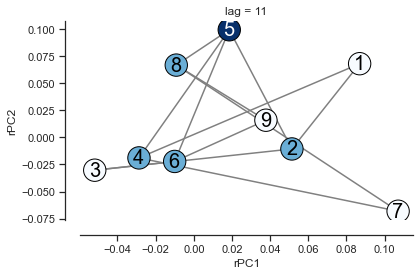

In [44]:
num_locs = max(Lags_array[0,:])

num_lags = 12
    
phase_planes_dic = {}
phase_specific_betas_dic = {}

centred_betas_dic = {
    0:centred_betas_1,
    1:centred_betas_1
}
for stack in range(2):
    for i in range(num_lags):
        
        if i not in phase_planes_dic:
            phase_planes_dic[i]=[]
        if i not in phase_specific_betas_dic:
            phase_specific_betas_dic[i]=[]
            
        ind1 = (i * num_locs).astype(int)
        ind2 = (i*num_locs+num_locs).astype(int)

        phase_specific_betas = centred_betas_dic[stack][:,ind1:ind2].T
        phase_specific_betas_dic[i].append(phase_specific_betas)
        pca_phase = PCA(n_components=2)
        pca_phase.fit(phase_specific_betas)
        subspace_vectors = pca_phase.components_
        
        phase_planes_dic[i].append(subspace_vectors)
    
        projection = phase_specific_betas.dot(subspace_vectors.T)
        
        if stack==0:  #only plot for first partition
    #         ax = plt.figure().add_subplot(projection='3d')
    #         for connection in connections:
    #             y = projection[connection[0],1], projection[connection[1],1]
    #             x = projection[connection[0],0], projection[connection[1],0]
    #             z = projection[connection[0],2], projection[connection[1],2]
    #             ax.plot(y,x,z, color='k')

    #         ax.scatter(projection[:,1], projection[:,0], projection[:,2], 
    #                    c=list(range(len(projection[:,1]))),
    #                    s=100, zorder=4)
    
            fig, ax=plt.subplots()
       
            sns.set_style('white')  # You can customize the style if needed
            sns.set_theme(style="ticks")
            sns.despine(bottom=False, left=False,offset=15)


            for connection in connections:
                y = projection[connection[0],1], projection[connection[1],1]
                x = projection[connection[0],0], projection[connection[1],0]
                ax.plot(y,x, color='gray')

            sc = ax.scatter(projection[:,1], projection[:,0],
                       c=degrees,
                       s=500, zorder=4, cmap='Blues', edgecolors='black')


            node_labels = list(range(1,len(projection[:,1])+1))
            xx=0
            for label, x_point, y_point in zip(node_labels, projection[:,1], projection[:,0]):
                ax.annotate(label,
                            xy=(x_point, y_point),
                            xytext=(-6,-6),
                            textcoords='offset pixels',
                            zorder=5,
                            color=colors_for_annotation[xx],
                            size=20)
                xx+=1
            ax.set_title(f'lag = {i}')
            ax.set_xlabel('rPC1')
            ax.set_ylabel('rPC2')
            plt.tight_layout()
#             fig.savefig(f'/Users/AdamHarris/Desktop/task_lag_subspace_lagupto13_{i}.svg',  dpi=300, bbox_inches = "tight")
#             plt.close(fig)
        
    

In [45]:
# for i in range(0,5):
    
#     proj_congruent = phase_specific_betas_dic[0][1]
#     proj_incongruent = phase_specific_betas_dic[i][1]
#     subspace_vectors = phase_planes_dic[0][1]
#     if i==0:
#         proj_incongruent = phase_specific_betas_dic[i][0] 
#     proj_1 = proj_congruent.dot(subspace_vectors.T)
#     proj_2 = proj_incongruent.dot(subspace_vectors.T)

#     ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
#     ax.set_title(f'lag_0 vs lag_{i}')
#     for connection in connections:
#         y = proj_1[connection[0],1], proj_1[connection[1],1]
#         x = proj_1[connection[0],0], proj_1[connection[1],0]
#         z = proj_1[connection[0],2], proj_1[connection[1],2]
#         ax.plot(y,x,z, color='k')

#         y2 = proj_2[connection[0],1], proj_2[connection[1],1]
#         x2 = proj_2[connection[0],0], proj_2[connection[1],0]
#         z2 = proj_2[connection[0],2], proj_2[connection[1],2]
#         ax.plot(y2,x2,z2, color='gray')

#     ax.scatter(proj_1[:,1], proj_1[:,0], proj_1[:,2], 
#                c=list(range(len(proj_1[:,1]))),
#                s=100, zorder=4, cmap = 'viridis')

#     ax.scatter(proj_2[:,1], proj_2[:,0], proj_2[:,2], 
#                c=list(range(len(proj_2[:,1]))),
#                s=100, zorder=4, cmap = 'inferno')
#     plt.show()


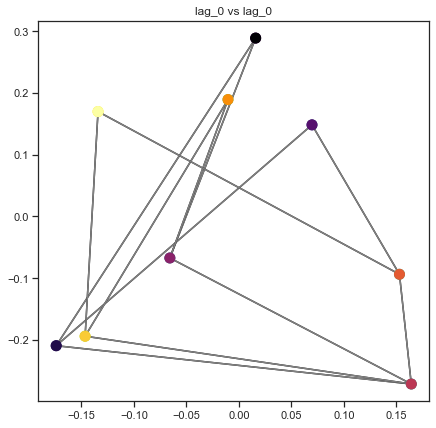

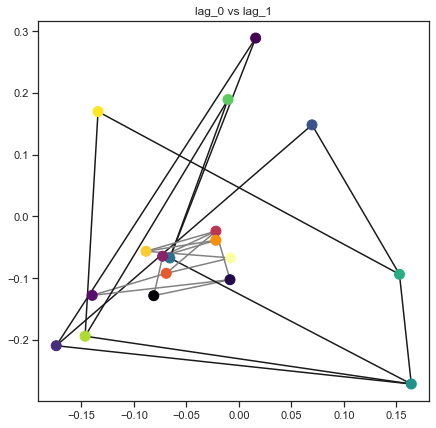

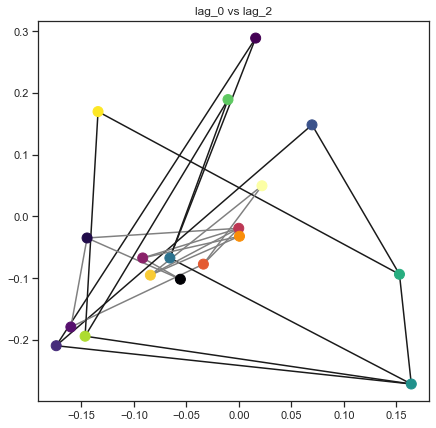

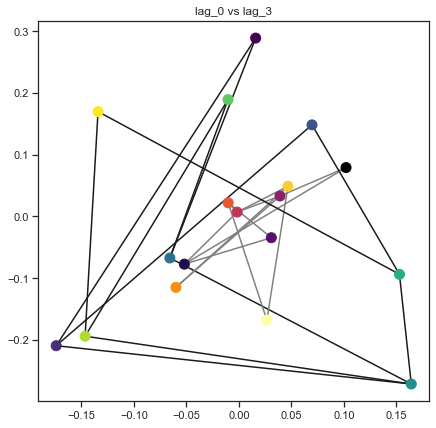

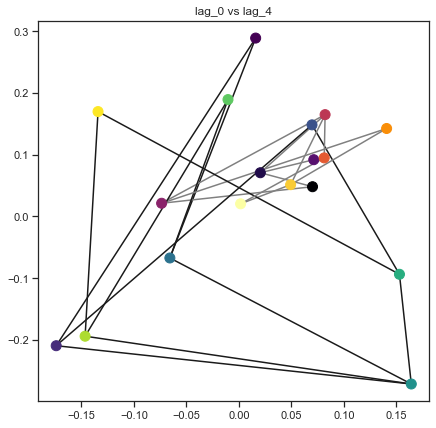

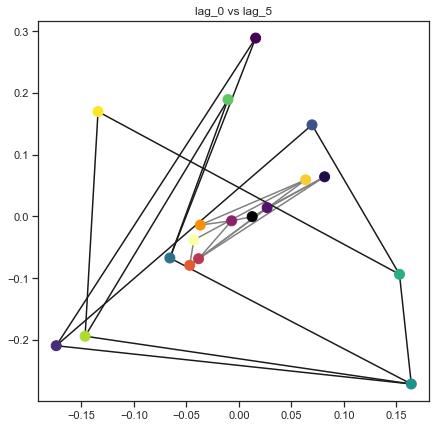

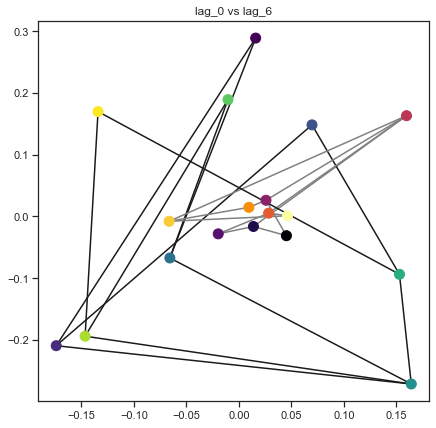

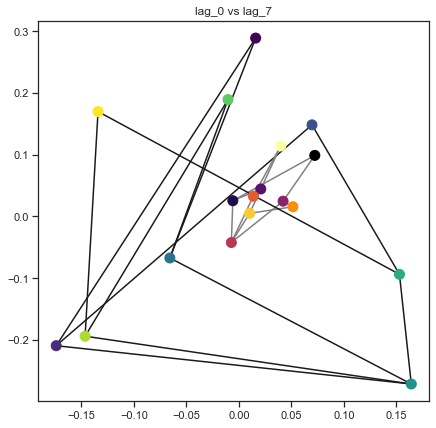

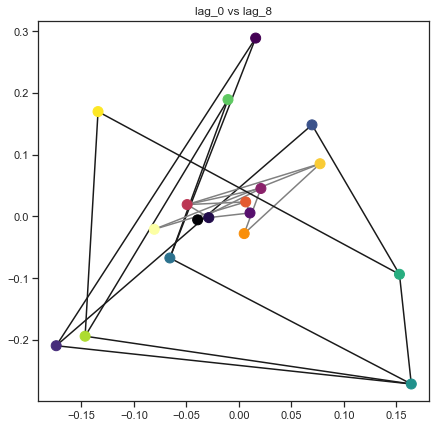

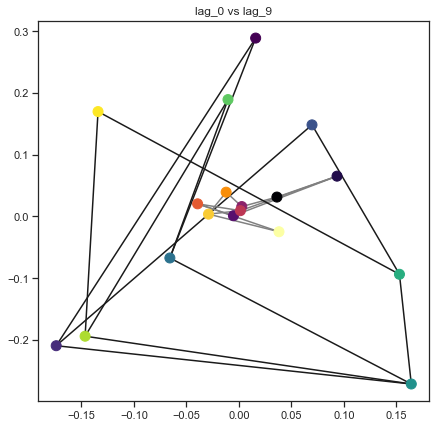

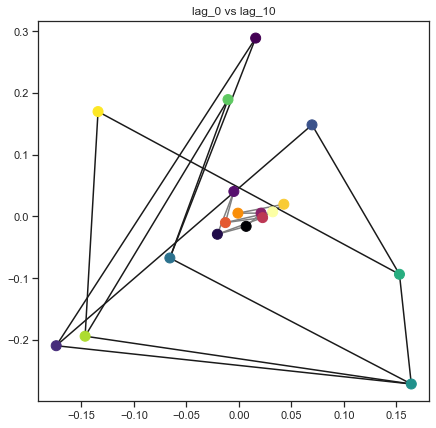

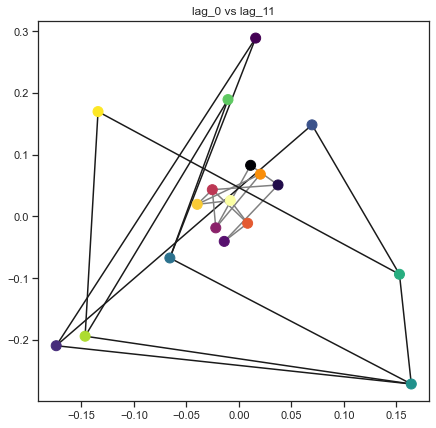

In [46]:
for i in range(0,12):
    
    proj_congruent = phase_specific_betas_dic[0][1]
    proj_incongruent = phase_specific_betas_dic[i][1]
    subspace_vectors = phase_planes_dic[0][1][:2,:]
    if i==0:
        proj_incongruent = phase_specific_betas_dic[i][0] 
    proj_1 = proj_congruent.dot(subspace_vectors.T)
    proj_2 = proj_incongruent.dot(subspace_vectors.T)

    ax = plt.figure(figsize=(7,7)).add_subplot()
    ax.set_title(f'lag_0 vs lag_{i}')
    for connection in connections:
        y = proj_1[connection[0],1], proj_1[connection[1],1]
        x = proj_1[connection[0],0], proj_1[connection[1],0]
      
        ax.plot(y,x, color='k')

        y2 = proj_2[connection[0],1], proj_2[connection[1],1]
        x2 = proj_2[connection[0],0], proj_2[connection[1],0]
       
        ax.plot(y2,x2, color='gray')

    ax.scatter(proj_1[:,1], proj_1[:,0], 
               c=list(range(len(proj_1[:,1]))),
               s=100, zorder=4, cmap = 'viridis')

    ax.scatter(proj_2[:,1], proj_2[:,0], 
               c=list(range(len(proj_2[:,1]))),
               s=100, zorder=4, cmap = 'inferno')
    plt.show()

In [47]:
#### self_comps  
angles_self = []
for i in phase_planes_dic:
    plane1 = phase_planes_dic[i][0]
    plane2 = phase_planes_dic[i][1]
    outer_product = plane1.dot(plane2.T)
    U, S, Vt = np.linalg.svd(outer_product, full_matrices=True)
    principal_angle = S[0]
    angles_self.append(principal_angle) 
    
angles_across = []
dist = []
# if phase_partitions ==3:
#     comps =[[0,1],
#             [0,2],
#             [1,2]]

# if phase_partitions ==5:
#     comps =[[0,1],
#             [0,2],
#             [0,3],
#             [0,4],
#             [2,4]]

comps = []
for i,_ in enumerate(phase_planes_dic):
    for j,_ in enumerate(phase_planes_dic):
        if i<=j:
            comps.append([i,j])
    

for comp in comps:
    plane1 = phase_planes_dic[comp[0]][0]
    plane2 = phase_planes_dic[comp[1]][1]
    outer_product = plane1.dot(plane2.T)
    U, S, Vt = np.linalg.svd(outer_product, full_matrices=True)
    principal_angle = S[0]
    angles_across.append(principal_angle) 
    dist.append((comp[1]-comp[0]))

(0.5564213976935646, 1.2267728938542265e-07)


/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


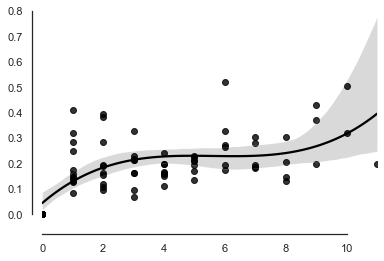

In [48]:

print(pearsonr(dist, 1-np.array(angles_across)))
sns.set_style('white')
sns.regplot(dist, 1-np.array(angles_across), color='black', order=3)
sns.despine(offset=10, trim=True);

/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 58.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


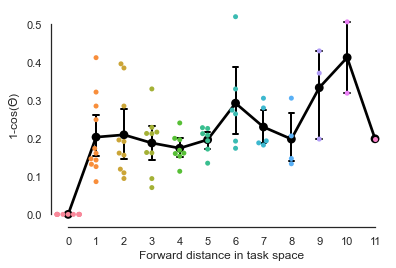

In [49]:
plot_dict = {
    'forward_dist': dist,
    'subspace_angle': 1-np.array(angles_across)
}


fig, ax=plt.subplots()
sns.set_style('white', {'axes.linewidth': 20, 'axes.edgecolor':'black'})  # You can customize the style if needed


ax = sns.swarmplot(x="forward_dist", y="subspace_angle", data=plot_dict)
sns.set_theme(style="ticks")

# Add mean and standard error bars using sns.barplot
sns.pointplot(x="forward_dist", y="subspace_angle", data=plot_dict, ax=ax,  errorbar='se', capsize=0.2, errwidth=2, color="black")

# Set labels and title
ax.set_xlabel("Forward distance in task space")
ax.set_ylabel("1-cos($\Theta$)")

sns.despine(bottom=False, left=False,offset=3, trim=True)


# Show the plot
plt.show()
fig.savefig(f"/Users/AdamHarris/Desktop/Task lag angles{phase_type}.svg", dpi=300, bbox_inches = "tight")

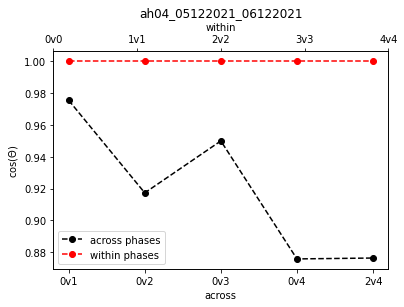

In [556]:
if phase_partitions==5:
    fig, ax = plt.subplots()

    ax.plot(angles_across, linestyle='--', marker='o', color='k', label='across phases')
    ax.plot(angles_self, linestyle='--', marker='o', color='r', label='within phases')
    plt.ylabel(r"$\cos({\Theta})$")
    plt.xlabel('across')
    plt.legend()

    plt.xticks(ticks = [0,1,2, 3, 4], labels=['0v1','0v2','0v3','0v4','2v4'])
    plt.title(mouse_recday)
    ax2 = ax.twiny()

    # Define the positions and labels for the second set of x-ticks
    new_xticks_positions = [0, 1, 2, 3, 4]
    new_xticks_labels = ['0v0', '1v1', '2v2', '3v3', '4v4']

    # Set the positions of the second x-axis ticks
    ax2.set_xticks(new_xticks_positions)

    # Set the labels for the second x-axis ticks
    ax2.set_xticklabels(new_xticks_labels)

    # Set the label for the second x-axis
    ax2.set_xlabel('within')


if phase_partitions ==3:
    fig, ax = plt.subplots()

    ax.plot(angles_across, linestyle='--', marker='o', color='k', label='across phases')
    ax.plot(angles_self, linestyle='--', marker='o', color='r', label='within phases')
    plt.ylabel(r"$\cos({\Theta})$")
    plt.xlabel('across')
    plt.legend()

    plt.xticks(ticks = [0,1,2], labels=['0v1',  '0v2', '1 v 2'])
    plt.title(mouse_recday)
    ax2 = ax.twiny()

    # Define the positions and labels for the second set of x-ticks
    new_xticks_positions = [0, 1, 2]
    new_xticks_labels = ['0v0', '1v1', '2v2']

    # Set the positions of the second x-axis ticks
    ax2.set_xticks(new_xticks_positions)

    # Set the labels for the second x-axis ticks
    ax2.set_xticklabels(new_xticks_labels)

    # Set the label for the second x-axis
    ax2.set_xlabel('within')


In [571]:
XY_raw = np.load(Data_folder+'XY_raw_'+mouse_recday+'_'+str(session)+'.npy')

In [583]:
def smooth_and_calculate_scalar_derivatives(data_matrix, sigma=3, dt=1.0):
    # Assuming data_matrix is an nx2 array with x and y positions

    # Separate x and y columns
    x_positions = data_matrix[:, 0]
    y_positions = data_matrix[:, 1]

    # Smooth the data using 1D Gaussian filter
    x_smoothed = gaussian_filter1d(x_positions, sigma=sigma)
    y_smoothed = gaussian_filter1d(y_positions, sigma=sigma)

    
    # Calculate speeds (first derivative) and magnitudes
    vx = np.gradient(x_smoothed, dt)
    vy = np.gradient(y_smoothed, dt)
    speed = np.sqrt(vx**2 + vy**2)

    # calculate acceleration
    acceleration = np.gradient(speed, dt)
    # Combine results into a single array
    smoothed_data = np.column_stack((x_smoothed, y_smoothed, speed, acceleration, distance))

    return smoothed_data

XY_processed = smooth_and_calculate_scalar_derivatives(XY_raw, sigma=5
                                                      )

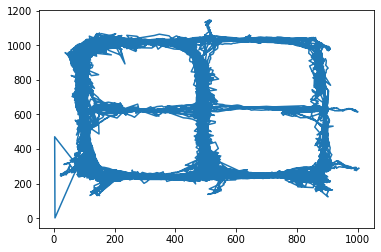

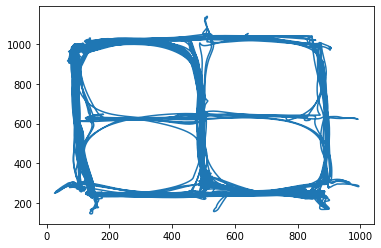

In [584]:
plt.plot(XY_raw[:,1], XY_raw[:,0])
plt.show()
plt.plot(XY_processed[:,1],XY_processed[:,0])
plt.show()


/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


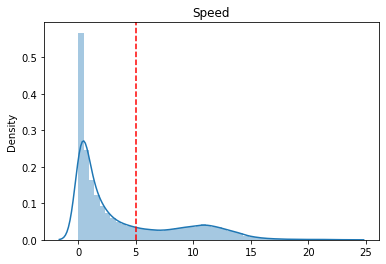

/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


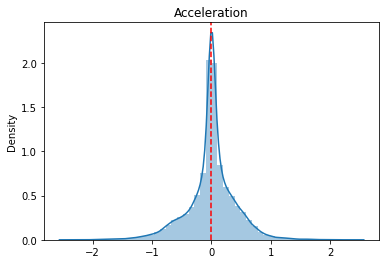

In [642]:
speed = XY_processed[:,2]
acceleration = XY_processed[:,3]
sns.distplot(speed)
plt.axvline(x=5, color='red', linestyle='--', label='thresh')
plt.title('Speed')
plt.show()
sns.distplot(acceleration)
plt.title('Acceleration')
plt.axvline(x=0, color='red', linestyle='--', label='thresh')
plt.show()

In [720]:
# sessions, Tasks = get_sessions(mouse_recday)
phase_partitions = 5
downsample_factor=5
speed_threshold = 5
acceleration_threshold = 0
phase_type = 'distance'   #distance or time
conf_group='acceleration+'   # speed+ speed-  acceleration+  acceleraion -

for counter, session in enumerate(sessions):
    
    task = Tasks[session]
    
    Neuron_raw=np.load(Data_folder+'Neuron_raw_'+mouse_recday+'_'+str(session)+'.npy')
    Location_raw=np.load(Data_folder+'Location_raw_'+mouse_recday+'_'+str(session)+'.npy')
    
    XY_raw = np.load(Data_folder+'XY_raw_'+mouse_recday+'_'+str(session)+'.npy')
    XY_processed = smooth_and_calculate_scalar_derivatives(XY_raw, sigma=5)
    speed = XY_processed[:,2]
    acceleration = XY_processed[:,3]

    Trial_times=np.load(Data_folder+'trialtimes_'+mouse_recday+'_'+str(session)+'.npy')
    #data_neurons=np.load(Data_folder+'Neuron_'+mouse_recday+'_'+str(session)+'.npy')
    
    # downsample neurons and locations
    Neuron_raw_downsampled=average_over_factor(Neuron_raw, downsample_factor)
    Location_raw_downsampled=sample_every_nth(Location_raw, downsample_factor)
    speed_downsampled = average_over_factor_1d(speed, downsample_factor)
    acceleration_downsampled = average_over_factor_1d(acceleration, downsample_factor)
    #use trial_times to get phase labels
    Trial_times_sr_adj = (Trial_times/25).astype(int)
    
    
    for trial_num, trial in enumerate(Trial_times_sr_adj):
        for state, _ in enumerate(trial[:-1]):
            
            state_length = trial[state+1]-trial[state]
            
            if phase_type=='time':
                phase_length = math.floor(state_length/phase_partitions)

                if phase_partitions==3:
                    phase_state = np.hstack((np.repeat(0, phase_length), 
                                            np.repeat(1, phase_length),
                                            np.repeat(2, phase_length)))
                if phase_partitions ==5:
                    phase_state = np.hstack((np.repeat(0, phase_length), 
                                            np.repeat(1, phase_length),
                                            np.repeat(2, phase_length),
                                            np.repeat(3, phase_length),
                                            np.repeat(4, phase_length)))
                
                error=state_length-phase_partitions*phase_length
                error_add_on = np.repeat(phase_partitions-1, error)
                phase_state=np.hstack((phase_state, error_add_on))
                
                
            if phase_type=='distance':
                
                movements_state = speed[trial[state]:trial[state+1]]
                cumulative_distance = np.cumsum(movements_state)
                max_distance = cumulative_distance[-1]
                distance_proportion = cumulative_distance/max_distance
                phase_dist_ = math.floor(1/phase_partitions)
                phase_thresholds = np.linspace(0, 1, num=phase_partitions+1, endpoint=True)
                phase_state = np.digitize(distance_proportion, phase_thresholds, right=True)
                phase_state = phase_state-1

            
            if state==0:
                phase_trial = phase_state
            else:
                phase_trial = np.hstack((phase_trial, phase_state))
                
        if trial_num==0:
            phase_session = phase_trial
        else:
            phase_session = np.hstack((phase_session, phase_trial))
            

    
    Phase_raw_downsampled=sample_every_nth(phase_session, downsample_factor)
    print('_____________________________________')
    print(f'Bin_counts: neurons {Neuron_raw_downsampled.shape[1]}, \n'
            f'loctions {len(Location_raw_downsampled)}, \n'
            f'phases {len(Phase_raw_downsampled)}')
            
    min_ind = min(Neuron_raw_downsampled.shape[1], 
                  len(Location_raw_downsampled), 
                  len(Phase_raw_downsampled),
                  len(speed_downsampled),
                  len(acceleration_downsampled))
    
    
    #make sure all the arrays are the same length
    
    Neuron_raw_downsampled = Neuron_raw_downsampled[:,:min_ind]
    Location_raw_downsampled = Location_raw_downsampled[:min_ind]
    Phase_raw_downsampled = Phase_raw_downsampled[:min_ind]
    speed_downsampled = speed_downsampled[:min_ind]
    acceleration_downsampled = acceleration_downsampled[:min_ind]
    
    
    
    # remove bins where the mouse is on an edge not a node
    mask=Location_raw_downsampled<10
    
    Phase_downsampled_nodes_only = Phase_raw_downsampled[mask]
    Location_downsampled_nodes_only = Location_raw_downsampled[mask]
    Neuron_downsampled_nodes_only = Neuron_raw_downsampled[:,mask]
    speed_downsampled_nodes_only = speed_downsampled[mask]
    acceleration_downsampled_nodes_only = acceleration_downsampled[mask]
    
    if conf_group!=[]:
        if conf_group not in ['speed+', 'speed-', 'acceleration+', 'acceleration-']:
            raise ValueError('not a valid confound group')
        else:
            if conf_group=='speed+':
                mask2 = speed_downsampled_nodes_only>speed_threshold
            if conf_group=='speed-':
                mask2 = speed_downsampled_nodes_only<speed_threshold
            if conf_group=='acceleration+':
                mask2 = acceleration_downsampled_nodes_only>acceleration_threshold
            if conf_group=='acceleration-':
                mask2 = acceleration_downsampled_nodes_only<acceleration_threshold
        
            Phase_downsampled_nodes_only = Phase_downsampled_nodes_only[mask2]
            Location_downsampled_nodes_only = Location_downsampled_nodes_only[mask2]
            Neuron_downsampled_nodes_only = Neuron_downsampled_nodes_only[:,mask2]
            speed_downsampled_nodes_only = speed_downsampled_nodes_only[mask2]
            acceleration_downsampled_nodes_only = acceleration_downsampled_nodes_only[mask2]
    
    print('-  -  -  -  -  -  -  -  -  -  -  -  - ')
    
    print('Removed bins where animal is on edge not node')
    
    print(f'Bin_counts: neurons {Neuron_downsampled_nodes_only.shape[1]}, \n'
            f'loctions {len(Location_downsampled_nodes_only)}, \n'
            f'phases {len(Phase_downsampled_nodes_only)}')
    
   
    
    #initialise data arrays
    if counter == 0:
        Neuron_array = Neuron_downsampled_nodes_only
        Location_array = Location_downsampled_nodes_only
        Phase_array = Phase_downsampled_nodes_only
    else:
        Neuron_array = np.hstack((Neuron_array, Neuron_downsampled_nodes_only))
        Location_array = np.hstack((Location_array, Location_downsampled_nodes_only)).astype(int)
        Phase_array = np.hstack((Phase_array, Phase_downsampled_nodes_only))

_____________________________________
Bin_counts: neurons 9051, 
loctions 9051, 
phases 9050
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 4104, 
loctions 4104, 
phases 4104
_____________________________________
Bin_counts: neurons 8452, 
loctions 8452, 
phases 8452
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 3891, 
loctions 3891, 
phases 3891
_____________________________________
Bin_counts: neurons 6968, 
loctions 6968, 
phases 6967
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 3167, 
loctions 3167, 
phases 3167
_____________________________________
Bin_counts: neurons 8606, 
loctions 8606, 
phases 8605
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 3881, 
loctions 3881, 
phases 3881
_____________________________________
Bin_counts: neurons 5336, 
loc

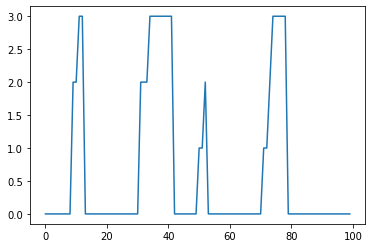

In [721]:
plt.plot(Phase_array[:100])

In [722]:
Location_array.shape

(25064,)

In [723]:
Phase_array.shape

(25064,)

In [724]:
from tqdm import tqdm
one_hot_all = []
for i,j in tqdm(zip(Location_array, Phase_array)):
    one_hot = np.zeros((phase_partitions, max(Location_array.astype(int))))
    one_hot[j,i-1]=1
#     one_hot = np.zeros((max(Location_array.astype(int)),))
#     one_hot[i-1]=1
    one_hot_all.append(one_hot.flatten())
    
one_hot_all = np.array(one_hot_all)

25064it [00:34, 728.42it/s]


In [725]:
one_hot_all.shape

(25064, 45)

In [726]:
NUM_ITERS = 50
NUM_NEURONS = Neuron_array.shape[0]
NUM_REGRESSORS = np.array(one_hot_all).shape[1]
LASSO_PARAM = 0.00005

for iteration in tqdm(range(NUM_ITERS)):
    
    split_1_mask = np.random.choice([0, 1], size=(len(Location_array),), p=[0.5, 0.5]).astype(bool)
    split_2_mask = ~split_1_mask
    
    betas_array_1 = np.zeros((NUM_NEURONS, NUM_REGRESSORS))
    betas_array_2 = np.zeros((NUM_NEURONS, NUM_REGRESSORS))
    
    for neuron, activity_array in enumerate(Neuron_array):
        
        activity_array_split_1 = activity_array[split_1_mask]
        activity_array_split_2 = activity_array[split_2_mask]
        
        one_hot_all_split_1 = one_hot_all[split_1_mask, :]
        one_hot_all_split_2 = one_hot_all[split_2_mask, :]
        
        lasso_1 = Lasso(alpha = LASSO_PARAM)
        lasso_1.fit(one_hot_all_split_1, activity_array_split_1)
        betas_1 = lasso_1.coef_
        
        lasso_2 = Lasso(alpha = LASSO_PARAM)
        lasso_2.fit(one_hot_all_split_2, activity_array_split_2)
        betas_2 = lasso_2.coef_
        
        betas_array_1[neuron,:]=betas_1
        betas_array_2[neuron,:]=betas_2
        
        
    if iteration==0:
        stacked_betas = np.stack((betas_array_1, betas_array_2))
    else:
        stacked_betas = np.concatenate((stacked_betas, np.expand_dims(betas_array_1, axis=0)), axis=0)
        stacked_betas = np.concatenate((stacked_betas, np.expand_dims(betas_array_2, axis=0)), axis=0)
        
        
num_stacks_in_split = math.floor(stacked_betas.shape[0]/2)

stack_split_1 = stacked_betas[:num_stacks_in_split,:,:]
stack_split_2 = stacked_betas[num_stacks_in_split:,:,:]

mean_betas_1 = np.nanmean(stack_split_1, axis=0)
mean_betas_2 = np.nanmean(stack_split_2, axis=0)


row_means_1 = np.mean(mean_betas_1, axis=1, keepdims=True)
row_means_2 = np.mean(mean_betas_2, axis=1, keepdims=True)

centred_betas_1 = mean_betas_1 - row_means_1
centred_betas_2 = mean_betas_2 - row_means_2
        

100%|██████████| 50/50 [02:25<00:00,  2.92s/it]


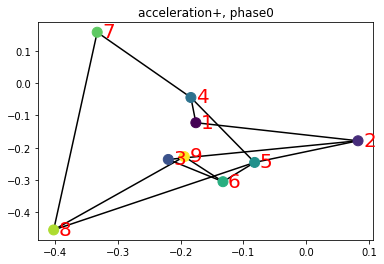

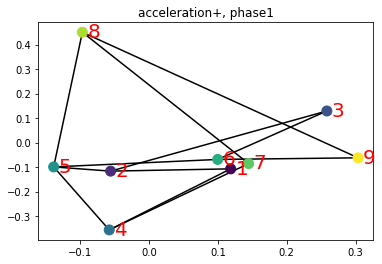

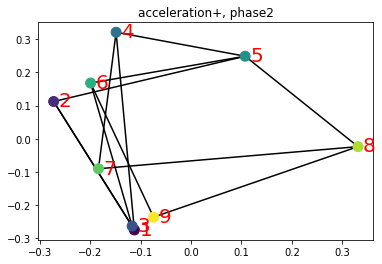

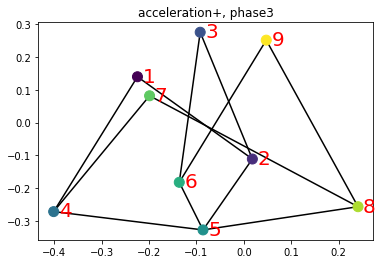

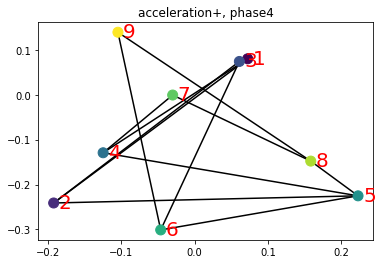

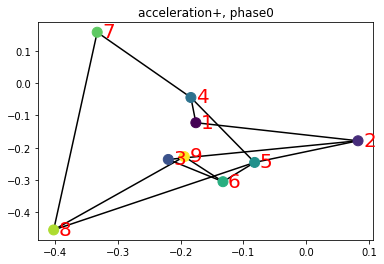

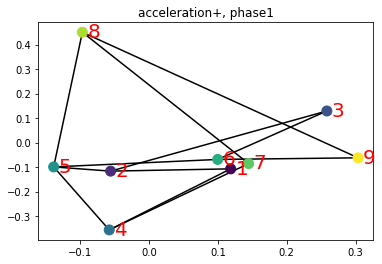

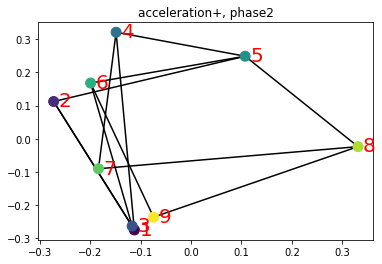

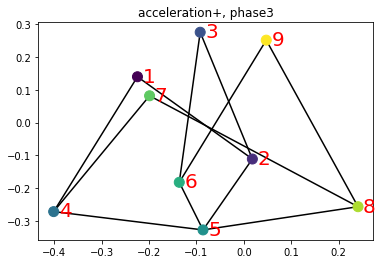

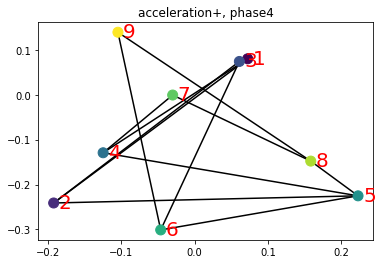

In [727]:
num_locs = max(Location_array)


if phase_partitions==5:
    phase_planes_dic = {
        0:[],
        1:[],
        2:[],
        3:[],
        4:[]
    }
    phase_specific_betas_dic = {
        0:[],
        1:[],
        2:[],
        3:[],
        4:[]
    }

if phase_partitions==3:
    phase_planes_dic = {
        0:[],
        1:[],
        2:[]
    }
    phase_specific_betas_dic = {
        0:[],
        1:[],
        2:[],
    }


centred_betas_dic = {
    0:centred_betas_1,
    1:centred_betas_1
}
for stack in range(2):
    for i in range(phase_partitions):
        ind1 = i * num_locs
        ind2 = i*num_locs+num_locs
        phase_specific_betas = centred_betas_dic[stack][:,ind1:ind2].T
        phase_specific_betas_dic[i].append(phase_specific_betas)
        pca_phase = PCA(n_components=3)
        pca_phase.fit(phase_specific_betas)
        subspace_vectors = pca_phase.components_
        
        phase_planes_dic[i].append(subspace_vectors)
    
        projection = phase_specific_betas.dot(subspace_vectors.T)
#         ax = plt.figure().add_subplot(projection='3d')
#         for connection in connections:
#             y = projection[connection[0],1], projection[connection[1],1]
#             x = projection[connection[0],0], projection[connection[1],0]
#             z = projection[connection[0],2], projection[connection[1],2]
#             ax.plot(y,x,z, color='k')
        
#         ax.scatter(projection[:,1], projection[:,0], projection[:,2], 
#                    c=list(range(len(projection[:,1]))),
#                    s=100, zorder=4)
        
#         node_labels = list(range(1,len(projection[:,1])+1))
                           
# #         for label, x_point, y_point, z_point in zip(node_labels, projection[:,1], projection[:,0]):
# #             ax.annotate(label,
# #                         xy=(x_point, y_point),
# #                         xytext=(5, -5),
# #                         textcoords='offset points',
# #                        zorder=5,
# #                        color='r',
# #                        size=20)

#         ax.set_title(f'phase = {i}')
    
        ax = plt.figure().add_subplot()
        for connection in connections:
            y = projection[connection[0],1], projection[connection[1],1]
            x = projection[connection[0],0], projection[connection[1],0]
           
            ax.plot(y,x, color='k')
        
        ax.scatter(projection[:,1], projection[:,0],
                   c=list(range(len(projection[:,1]))),
                   s=100, zorder=4)
        
        node_labels = list(range(1,len(projection[:,1])+1))
                           
        for label, x_point, y_point in zip(node_labels, projection[:,1], projection[:,0]):
            ax.annotate(label,
                        xy=(x_point, y_point),
                        xytext=(5, -5),
                        textcoords='offset points',
                       zorder=5,
                       color='r',
                       size=20)

        ax.set_title(f'{conf_group}, phase{i}')
        
        
        
    

In [684]:
NUM_ITERS = 50
NUM_NEURONS = Neuron_array.shape[0]
NUM_REGRESSORS = np.array(one_hot_all).shape[1]
LASSO_PARAM = 0.00005

for iteration in tqdm(range(NUM_ITERS)):
    
    split_1_mask = np.random.choice([0, 1], size=(len(Location_array),), p=[0.5, 0.5]).astype(bool)
    split_2_mask = ~split_1_mask
    
    betas_array_1 = np.zeros((NUM_NEURONS, NUM_REGRESSORS))
    betas_array_2 = np.zeros((NUM_NEURONS, NUM_REGRESSORS))
    
    for neuron, activity_array in enumerate(Neuron_array):
        
        activity_array_split_1 = activity_array[split_1_mask]
        activity_array_split_2 = activity_array[split_2_mask]
        
        one_hot_all_split_1 = one_hot_all[split_1_mask, :]
        one_hot_all_split_2 = one_hot_all[split_2_mask, :]
        
        lasso_1 = Lasso(alpha = LASSO_PARAM)
        lasso_1.fit(one_hot_all_split_1, activity_array_split_1)
        betas_1 = lasso_1.coef_
        
        lasso_2 = Lasso(alpha = LASSO_PARAM)
        lasso_2.fit(one_hot_all_split_2, activity_array_split_2)
        betas_2 = lasso_2.coef_
        
        betas_array_1[neuron,:]=betas_1
        betas_array_2[neuron,:]=betas_2
        
        
    if iteration==0:
        stacked_betas = np.stack((betas_array_1, betas_array_2))
    else:
        stacked_betas = np.concatenate((stacked_betas, np.expand_dims(betas_array_1, axis=0)), axis=0)
        stacked_betas = np.concatenate((stacked_betas, np.expand_dims(betas_array_2, axis=0)), axis=0)
        
        
num_stacks_in_split = math.floor(stacked_betas.shape[0]/2)

stack_split_1 = stacked_betas[:num_stacks_in_split,:,:]
stack_split_2 = stacked_betas[num_stacks_in_split:,:,:]

mean_betas_1 = np.nanmean(stack_split_1, axis=0)
mean_betas_2 = np.nanmean(stack_split_2, axis=0)


row_means_1 = np.mean(mean_betas_1, axis=1, keepdims=True)
row_means_2 = np.mean(mean_betas_2, axis=1, keepdims=True)

centred_betas_1 = mean_betas_1 - row_means_1
centred_betas_2 = mean_betas_2 - row_means_2
        

100%|██████████| 50/50 [03:30<00:00,  4.21s/it]


In [685]:
centred_betas_1.shape

(114, 45)

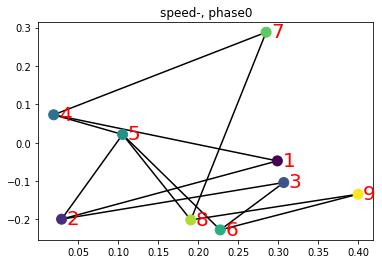

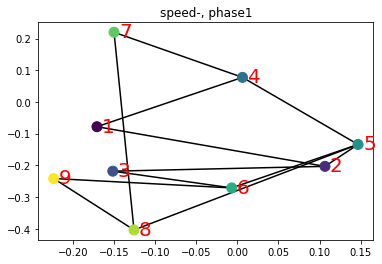

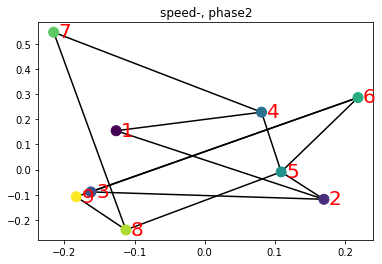

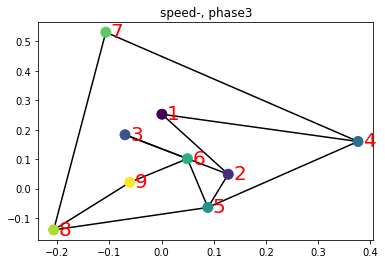

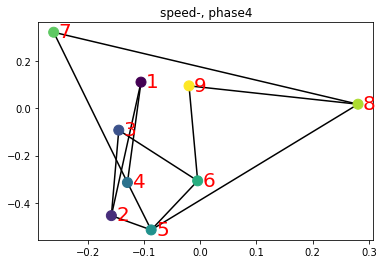

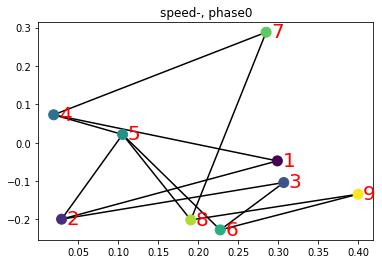

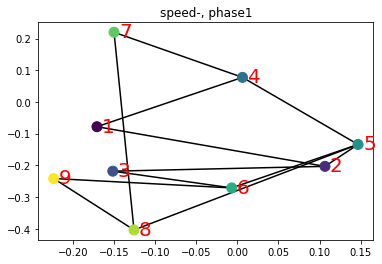

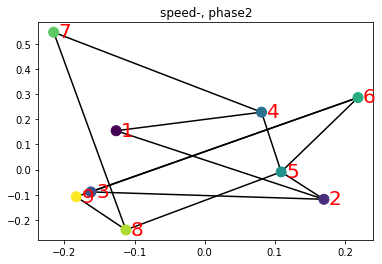

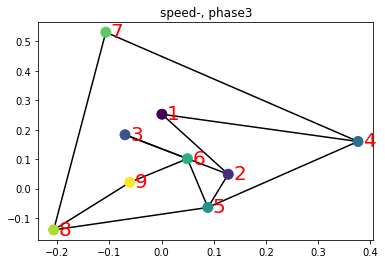

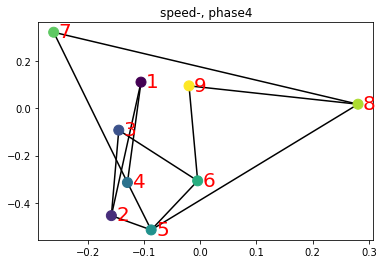

In [686]:
num_locs = max(Location_array)


if phase_partitions==5:
    phase_planes_dic = {
        0:[],
        1:[],
        2:[],
        3:[],
        4:[]
    }
    phase_specific_betas_dic = {
        0:[],
        1:[],
        2:[],
        3:[],
        4:[]
    }

if phase_partitions==3:
    phase_planes_dic = {
        0:[],
        1:[],
        2:[]
    }
    phase_specific_betas_dic = {
        0:[],
        1:[],
        2:[],
    }


centred_betas_dic = {
    0:centred_betas_1,
    1:centred_betas_1
}
for stack in range(2):
    for i in range(phase_partitions):
        ind1 = i * num_locs
        ind2 = i*num_locs+num_locs
        phase_specific_betas = centred_betas_dic[stack][:,ind1:ind2].T
        phase_specific_betas_dic[i].append(phase_specific_betas)
        pca_phase = PCA(n_components=3)
        pca_phase.fit(phase_specific_betas)
        subspace_vectors = pca_phase.components_
        
        phase_planes_dic[i].append(subspace_vectors)
    
        projection = phase_specific_betas.dot(subspace_vectors.T)
#         ax = plt.figure().add_subplot(projection='3d')
#         for connection in connections:
#             y = projection[connection[0],1], projection[connection[1],1]
#             x = projection[connection[0],0], projection[connection[1],0]
#             z = projection[connection[0],2], projection[connection[1],2]
#             ax.plot(y,x,z, color='k')
        
#         ax.scatter(projection[:,1], projection[:,0], projection[:,2], 
#                    c=list(range(len(projection[:,1]))),
#                    s=100, zorder=4)
        
#         node_labels = list(range(1,len(projection[:,1])+1))
                           
# #         for label, x_point, y_point, z_point in zip(node_labels, projection[:,1], projection[:,0]):
# #             ax.annotate(label,
# #                         xy=(x_point, y_point),
# #                         xytext=(5, -5),
# #                         textcoords='offset points',
# #                        zorder=5,
# #                        color='r',
# #                        size=20)

#         ax.set_title(f'phase = {i}')
    
        ax = plt.figure().add_subplot()
        for connection in connections:
            y = projection[connection[0],1], projection[connection[1],1]
            x = projection[connection[0],0], projection[connection[1],0]
           
            ax.plot(y,x, color='k')
        
        ax.scatter(projection[:,1], projection[:,0],
                   c=list(range(len(projection[:,1]))),
                   s=100, zorder=4)
        
        node_labels = list(range(1,len(projection[:,1])+1))
                           
        for label, x_point, y_point in zip(node_labels, projection[:,1], projection[:,0]):
            ax.annotate(label,
                        xy=(x_point, y_point),
                        xytext=(5, -5),
                        textcoords='offset points',
                       zorder=5,
                       color='r',
                       size=20)

        ax.set_title(f'{conf_group}, phase{i}')
        
        
        
    

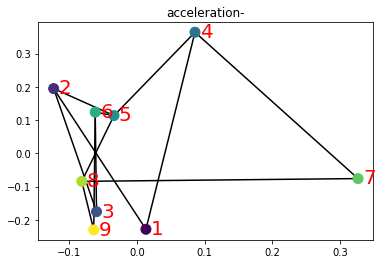

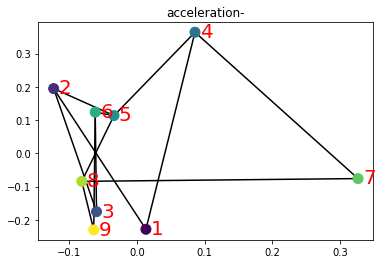

In [640]:
num_locs = max(Location_array)

centred_betas_dic = {
    0:centred_betas_1,
    1:centred_betas_1
}
for stack in range(2):
    
    ind1 = i * num_locs
    ind2 = i*num_locs+num_locs
    phase_specific_betas = centred_betas_dic[stack]
    pca_phase = PCA(n_components=2)
    pca_phase.fit(phase_specific_betas.T)
    subspace_vectors = pca_phase.components_



    projection = phase_specific_betas.T.dot(subspace_vectors.T)

    ax = plt.figure().add_subplot()
    for connection in connections:
        y = projection[connection[0],1], projection[connection[1],1]
        x = projection[connection[0],0], projection[connection[1],0]

        ax.plot(y,x, color='k')

    ax.scatter(projection[:,1], projection[:,0],
               c=list(range(len(projection[:,1]))),
               s=100, zorder=4)

    node_labels = list(range(1,len(projection[:,1])+1))

    for label, x_point, y_point in zip(node_labels, projection[:,1], projection[:,0]):
        ax.annotate(label,
                    xy=(x_point, y_point),
                    xytext=(5, -5),
                    textcoords='offset points',
                   zorder=5,
                   color='r',
                   size=20)

    ax.set_title(conf_group)





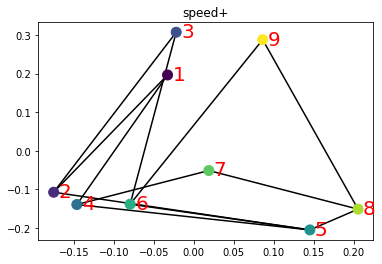

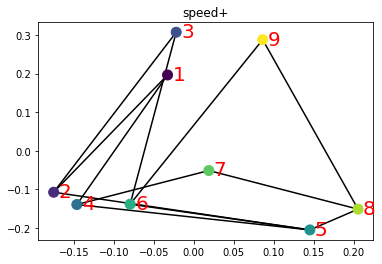

In [619]:
num_locs = max(Location_array)

centred_betas_dic = {
    0:centred_betas_1,
    1:centred_betas_1
}
for stack in range(2):
    
    ind1 = i * num_locs
    ind2 = i*num_locs+num_locs
    phase_specific_betas = centred_betas_dic[stack]
    pca_phase = PCA(n_components=2)
    pca_phase.fit(phase_specific_betas.T)
    subspace_vectors = pca_phase.components_



    projection = phase_specific_betas.T.dot(subspace_vectors.T)

    ax = plt.figure().add_subplot()
    for connection in connections:
        y = projection[connection[0],1], projection[connection[1],1]
        x = projection[connection[0],0], projection[connection[1],0]

        ax.plot(y,x, color='k')

    ax.scatter(projection[:,1], projection[:,0],
               c=list(range(len(projection[:,1]))),
               s=100, zorder=4)

    node_labels = list(range(1,len(projection[:,1])+1))

    for label, x_point, y_point in zip(node_labels, projection[:,1], projection[:,0]):
        ax.annotate(label,
                    xy=(x_point, y_point),
                    xytext=(5, -5),
                    textcoords='offset points',
                   zorder=5,
                   color='r',
                   size=20)

    ax.set_title(conf_group)





In [615]:
phase_specific_betas.shape

(114, 9)

In [731]:
# sessions, Tasks = get_sessions(mouse_recday)
phase_partitions = 5
downsample_factor=5
speed_threshold = 5
acceleration_threshold = 0
phase_type = 'distance'   #distance or time
conf_group='none'   # speed+ speed-  acceleration+  acceleraion-  none

for counter, session in enumerate(sessions):
    
    task = Tasks[session]
    
    Neuron_raw=np.load(Data_folder+'Neuron_raw_'+mouse_recday+'_'+str(session)+'.npy')
    Location_raw=np.load(Data_folder+'Location_raw_'+mouse_recday+'_'+str(session)+'.npy')
    
    XY_raw = np.load(Data_folder+'XY_raw_'+mouse_recday+'_'+str(session)+'.npy')
    XY_processed = smooth_and_calculate_scalar_derivatives(XY_raw, sigma=5)
    speed = XY_processed[:,2]
    acceleration = XY_processed[:,3]

    Trial_times=np.load(Data_folder+'trialtimes_'+mouse_recday+'_'+str(session)+'.npy')
    #data_neurons=np.load(Data_folder+'Neuron_'+mouse_recday+'_'+str(session)+'.npy')
    
    # downsample neurons and locations
    Neuron_raw_downsampled=average_over_factor(Neuron_raw, downsample_factor)
    Location_raw_downsampled=sample_every_nth(Location_raw, downsample_factor)
    speed_downsampled = average_over_factor_1d(speed, downsample_factor)
    acceleration_downsampled = average_over_factor_1d(acceleration, downsample_factor)
    #use trial_times to get phase labels
    Trial_times_sr_adj = (Trial_times/25).astype(int)
    
    
    for trial_num, trial in enumerate(Trial_times_sr_adj):
        for state, _ in enumerate(trial[:-1]):
            
            state_length = trial[state+1]-trial[state]
            
            if phase_type=='time':
                phase_length = math.floor(state_length/phase_partitions)

                if phase_partitions==3:
                    phase_state = np.hstack((np.repeat(0, phase_length), 
                                            np.repeat(1, phase_length),
                                            np.repeat(2, phase_length)))
                if phase_partitions ==5:
                    phase_state = np.hstack((np.repeat(0, phase_length), 
                                            np.repeat(1, phase_length),
                                            np.repeat(2, phase_length),
                                            np.repeat(3, phase_length),
                                            np.repeat(4, phase_length)))
                
                error=state_length-phase_partitions*phase_length
                error_add_on = np.repeat(phase_partitions-1, error)
                phase_state=np.hstack((phase_state, error_add_on))
                
                
            if phase_type=='distance':
                
                movements_state = speed[trial[state]:trial[state+1]]
                cumulative_distance = np.cumsum(movements_state)
                max_distance = cumulative_distance[-1]
                distance_proportion = cumulative_distance/max_distance
                phase_dist_ = math.floor(1/phase_partitions)
                phase_thresholds = np.linspace(0, 1, num=phase_partitions+1, endpoint=True)
                phase_state = np.digitize(distance_proportion, phase_thresholds, right=True)
                phase_state = phase_state-1

            
            if state==0:
                phase_trial = phase_state
            else:
                phase_trial = np.hstack((phase_trial, phase_state))
                
        if trial_num==0:
            phase_session = phase_trial
        else:
            phase_session = np.hstack((phase_session, phase_trial))
            

    
    Phase_raw_downsampled=sample_every_nth(phase_session, downsample_factor)
    print('_____________________________________')
    print(f'Bin_counts: neurons {Neuron_raw_downsampled.shape[1]}, \n'
            f'loctions {len(Location_raw_downsampled)}, \n'
            f'phases {len(Phase_raw_downsampled)}')
            
    min_ind = min(Neuron_raw_downsampled.shape[1], 
                  len(Location_raw_downsampled), 
                  len(Phase_raw_downsampled),
                  len(speed_downsampled),
                  len(acceleration_downsampled))
    
    
    #make sure all the arrays are the same length
    
    Neuron_raw_downsampled = Neuron_raw_downsampled[:,:min_ind]
    Location_raw_downsampled = Location_raw_downsampled[:min_ind]
    Phase_raw_downsampled = Phase_raw_downsampled[:min_ind]
    speed_downsampled = speed_downsampled[:min_ind]
    acceleration_downsampled = acceleration_downsampled[:min_ind]
    
    
    
    # remove bins where the mouse is on an edge not a node
    mask=Location_raw_downsampled<10
    
    Phase_downsampled_nodes_only = Phase_raw_downsampled[mask]
    Location_downsampled_nodes_only = Location_raw_downsampled[mask]
    Neuron_downsampled_nodes_only = Neuron_raw_downsampled[:,mask]
    speed_downsampled_nodes_only = speed_downsampled[mask]
    acceleration_downsampled_nodes_only = acceleration_downsampled[mask]
    
    if conf_group!=[]:
        if conf_group!='none':
            if conf_group not in ['speed+', 'speed-', 'acceleration+', 'acceleration-']:
                raise ValueError('not a valid confound group')
          
            if conf_group=='speed+':
                mask2 = speed_downsampled_nodes_only>speed_threshold
            if conf_group=='speed-':
                mask2 = speed_downsampled_nodes_only<speed_threshold
            if conf_group=='acceleration+':
                mask2 = acceleration_downsampled_nodes_only>acceleration_threshold
            if conf_group=='acceleration-':
                mask2 = acceleration_downsampled_nodes_only<acceleration_threshold

        
            Phase_downsampled_nodes_only = Phase_downsampled_nodes_only[mask2]
            Location_downsampled_nodes_only = Location_downsampled_nodes_only[mask2]
            Neuron_downsampled_nodes_only = Neuron_downsampled_nodes_only[:,mask2]
            speed_downsampled_nodes_only = speed_downsampled_nodes_only[mask2]
            acceleration_downsampled_nodes_only = acceleration_downsampled_nodes_only[mask2]
    
    print('-  -  -  -  -  -  -  -  -  -  -  -  - ')
    
    print('Removed bins where animal is on edge not node')
    
    print(f'Bin_counts: neurons {Neuron_downsampled_nodes_only.shape[1]}, \n'
            f'loctions {len(Location_downsampled_nodes_only)}, \n'
            f'phases {len(Phase_downsampled_nodes_only)}')
    
   
    
    #initialise data arrays
    if counter == 0:
        Neuron_array = Neuron_downsampled_nodes_only
        Location_array = Location_downsampled_nodes_only
        Phase_array = Phase_downsampled_nodes_only
    else:
        Neuron_array = np.hstack((Neuron_array, Neuron_downsampled_nodes_only))
        Location_array = np.hstack((Location_array, Location_downsampled_nodes_only)).astype(int)
        Phase_array = np.hstack((Phase_array, Phase_downsampled_nodes_only))

_____________________________________
Bin_counts: neurons 9051, 
loctions 9051, 
phases 9050
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 7560, 
loctions 7560, 
phases 7560
_____________________________________
Bin_counts: neurons 8452, 
loctions 8452, 
phases 8452
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 6979, 
loctions 6979, 
phases 6979
_____________________________________
Bin_counts: neurons 6968, 
loctions 6968, 
phases 6967
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 5879, 
loctions 5879, 
phases 5879
_____________________________________
Bin_counts: neurons 8606, 
loctions 8606, 
phases 8605
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 7231, 
loctions 7231, 
phases 7231
_____________________________________
Bin_counts: neurons 5336, 
loc

In [732]:
from tqdm import tqdm
one_hot_all = []
for i,j in tqdm(zip(Location_array, Phase_array)):
    one_hot = np.zeros((phase_partitions, max(Location_array.astype(int))))
    one_hot[j,i-1]=1
#     one_hot = np.zeros((max(Location_array.astype(int)),))
#     one_hot[i-1]=1
    one_hot_all.append(one_hot.flatten())
    
one_hot_all = np.array(one_hot_all)

46233it [01:54, 404.63it/s]


In [733]:
NUM_ITERS = 50
NUM_NEURONS = Neuron_array.shape[0]
NUM_REGRESSORS = np.array(one_hot_all).shape[1]
LASSO_PARAM = 0.00005

for iteration in tqdm(range(NUM_ITERS)):
    
    split_1_mask = np.random.choice([0, 1], size=(len(Location_array),), p=[0.5, 0.5]).astype(bool)
    split_2_mask = ~split_1_mask
    
    betas_array_1 = np.zeros((NUM_NEURONS, NUM_REGRESSORS))
    betas_array_2 = np.zeros((NUM_NEURONS, NUM_REGRESSORS))
    
    for neuron, activity_array in enumerate(Neuron_array):
        
        activity_array_split_1 = activity_array[split_1_mask]
        activity_array_split_2 = activity_array[split_2_mask]
        
        one_hot_all_split_1 = one_hot_all[split_1_mask, :]
        one_hot_all_split_2 = one_hot_all[split_2_mask, :]
        
        lasso_1 = Lasso(alpha = LASSO_PARAM)
        lasso_1.fit(one_hot_all_split_1, activity_array_split_1)
        betas_1 = lasso_1.coef_
        
        lasso_2 = Lasso(alpha = LASSO_PARAM)
        lasso_2.fit(one_hot_all_split_2, activity_array_split_2)
        betas_2 = lasso_2.coef_
        
        betas_array_1[neuron,:]=betas_1
        betas_array_2[neuron,:]=betas_2
        
        
    if iteration==0:
        stacked_betas = np.stack((betas_array_1, betas_array_2))
    else:
        stacked_betas = np.concatenate((stacked_betas, np.expand_dims(betas_array_1, axis=0)), axis=0)
        stacked_betas = np.concatenate((stacked_betas, np.expand_dims(betas_array_2, axis=0)), axis=0)
        
        
num_stacks_in_split = math.floor(stacked_betas.shape[0]/2)

stack_split_1 = stacked_betas[:num_stacks_in_split,:,:]
stack_split_2 = stacked_betas[num_stacks_in_split:,:,:]

mean_betas_1 = np.nanmean(stack_split_1, axis=0)
mean_betas_2 = np.nanmean(stack_split_2, axis=0)


row_means_1 = np.mean(mean_betas_1, axis=1, keepdims=True)
row_means_2 = np.mean(mean_betas_2, axis=1, keepdims=True)

centred_betas_1 = mean_betas_1 - row_means_1
centred_betas_2 = mean_betas_2 - row_means_2
        

100%|██████████| 50/50 [05:07<00:00,  6.16s/it]


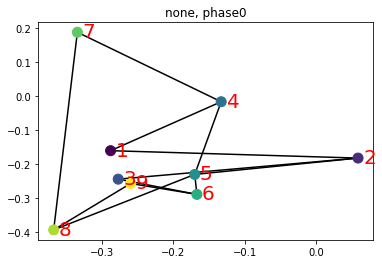

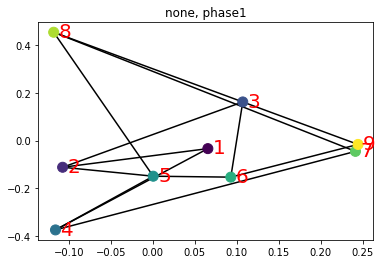

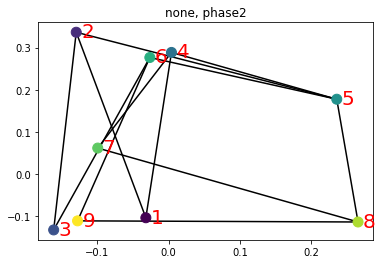

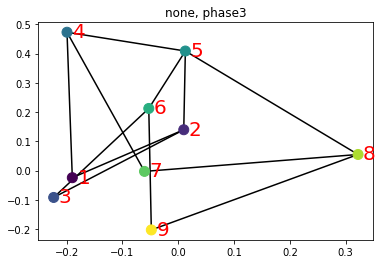

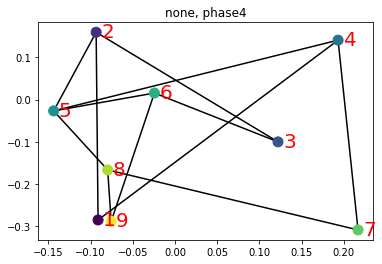

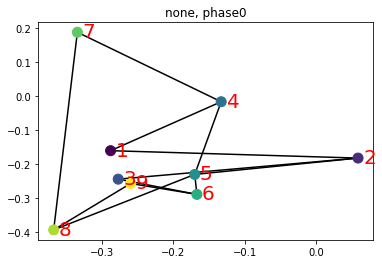

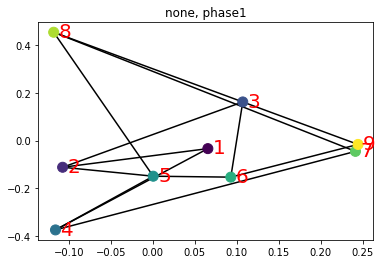

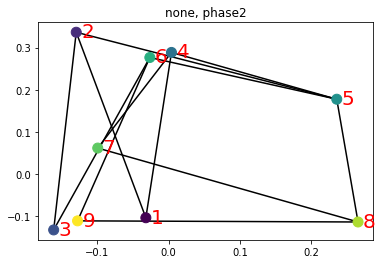

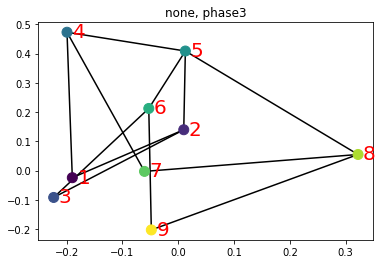

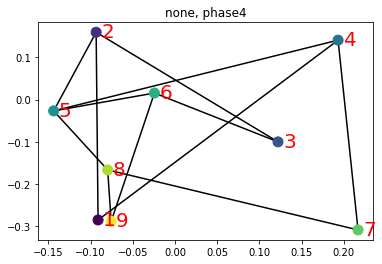

In [734]:
num_locs = max(Location_array)


if phase_partitions==5:
    phase_planes_dic = {
        0:[],
        1:[],
        2:[],
        3:[],
        4:[]
    }
    phase_specific_betas_dic = {
        0:[],
        1:[],
        2:[],
        3:[],
        4:[]
    }

if phase_partitions==3:
    phase_planes_dic = {
        0:[],
        1:[],
        2:[]
    }
    phase_specific_betas_dic = {
        0:[],
        1:[],
        2:[],
    }


centred_betas_dic = {
    0:centred_betas_1,
    1:centred_betas_1
}
for stack in range(2):
    for i in range(phase_partitions):
        ind1 = i * num_locs
        ind2 = i*num_locs+num_locs
        phase_specific_betas = centred_betas_dic[stack][:,ind1:ind2].T
        phase_specific_betas_dic[i].append(phase_specific_betas)
        pca_phase = PCA(n_components=3)
        pca_phase.fit(phase_specific_betas)
        subspace_vectors = pca_phase.components_
        
        phase_planes_dic[i].append(subspace_vectors)
    
        projection = phase_specific_betas.dot(subspace_vectors.T)
#         ax = plt.figure().add_subplot(projection='3d')
#         for connection in connections:
#             y = projection[connection[0],1], projection[connection[1],1]
#             x = projection[connection[0],0], projection[connection[1],0]
#             z = projection[connection[0],2], projection[connection[1],2]
#             ax.plot(y,x,z, color='k')
        
#         ax.scatter(projection[:,1], projection[:,0], projection[:,2], 
#                    c=list(range(len(projection[:,1]))),
#                    s=100, zorder=4)
        
#         node_labels = list(range(1,len(projection[:,1])+1))
                           
# #         for label, x_point, y_point, z_point in zip(node_labels, projection[:,1], projection[:,0]):
# #             ax.annotate(label,
# #                         xy=(x_point, y_point),
# #                         xytext=(5, -5),
# #                         textcoords='offset points',
# #                        zorder=5,
# #                        color='r',
# #                        size=20)

#         ax.set_title(f'phase = {i}')
    
        ax = plt.figure().add_subplot()
        for connection in connections:
            y = projection[connection[0],1], projection[connection[1],1]
            x = projection[connection[0],0], projection[connection[1],0]
           
            ax.plot(y,x, color='k')
        
        ax.scatter(projection[:,1], projection[:,0],
                   c=list(range(len(projection[:,1]))),
                   s=100, zorder=4)
        
        node_labels = list(range(1,len(projection[:,1])+1))
                           
        for label, x_point, y_point in zip(node_labels, projection[:,1], projection[:,0]):
            ax.annotate(label,
                        xy=(x_point, y_point),
                        xytext=(5, -5),
                        textcoords='offset points',
                       zorder=5,
                       color='r',
                       size=20)

        ax.set_title(f'{conf_group}, phase{i}')
        
        
        
    

In [740]:
#### self_comps  
angles_self = []
for i in phase_planes_dic:
    plane1 = phase_planes_dic[i][0]
    plane2 = phase_planes_dic[i][1]
    outer_product = plane1.dot(plane2.T)
    U, S, Vt = np.linalg.svd(outer_product, full_matrices=True)
    principal_angle = S[0]
    angles_self.append(principal_angle) 
    
angles_across = []

if phase_partitions ==3:
    comps =[[0,1],
            [0,2],
            [1,2]]

if phase_partitions ==5:
    comps =[[0,1],
            [0,2],
            [0,3],
            [0,4],
            [3,4]]

for comp in comps:
    plane1 = phase_planes_dic[comp[0]][0]
    plane2 = phase_planes_dic[comp[1]][1]
    outer_product = plane1.dot(plane2.T)
    U, S, Vt = np.linalg.svd(outer_product, full_matrices=True)
    principal_angle = S[0]
    angles_across.append(principal_angle) 

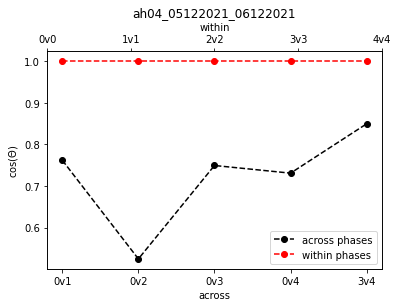

In [743]:
if phase_partitions==5:
    fig, ax = plt.subplots()

    ax.plot(angles_across, linestyle='--', marker='o', color='k', label='across phases')
    ax.plot(angles_self, linestyle='--', marker='o', color='r', label='within phases')
    plt.ylabel(r"$\cos({\Theta})$")
    plt.xlabel('across')
    plt.legend()

    plt.xticks(ticks = [0,1,2, 3, 4], labels=['0v1','0v2','0v3','0v4','3v4'])
    plt.title(mouse_recday)
    ax2 = ax.twiny()

    # Define the positions and labels for the second set of x-ticks
    new_xticks_positions = [0, 1, 2, 3, 4]
    new_xticks_labels = ['0v0', '1v1', '2v2', '3v3', '4v4']

    # Set the positions of the second x-axis ticks
    ax2.set_xticks(new_xticks_positions)

    # Set the labels for the second x-axis ticks
    ax2.set_xticklabels(new_xticks_labels)

    # Set the label for the second x-axis
    ax2.set_xlabel('within')


if phase_partitions ==3:
    fig, ax = plt.subplots()

    ax.plot(angles_across, linestyle='--', marker='o', color='k', label='across phases')
    ax.plot(angles_self, linestyle='--', marker='o', color='r', label='within phases')
    plt.ylabel(r"$\cos({\Theta})$")
    plt.xlabel('across')
    plt.legend()

    plt.xticks(ticks = [0,1,2], labels=['0v1',  '0v2', '1v2'])
    plt.title(mouse_recday)
    ax2 = ax.twiny()

    # Define the positions and labels for the second set of x-ticks
    new_xticks_positions = [0, 1, 2]
    new_xticks_labels = ['0v0', '1v1', '2v2']

    # Set the positions of the second x-axis ticks
    ax2.set_xticks(new_xticks_positions)

    # Set the labels for the second x-axis ticks
    ax2.set_xticklabels(new_xticks_labels)

    # Set the label for the second x-axis
    ax2.set_xlabel('within')


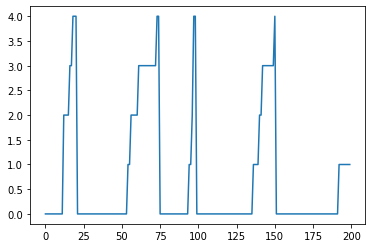

In [745]:
plt.plot(Phase_array[:200])

In [557]:
# sessions, Tasks = get_sessions(mouse_recday)
phase_partitions = 5
downsample_factor=10


for counter, session in enumerate(sessions):
    
    task = Tasks[session]
    Neuron_raw=np.load(Data_folder+'Neuron_raw_'+mouse_recday+'_'+str(session)+'.npy')
    Location_raw=np.load(Data_folder+'Location_raw_'+mouse_recday+'_'+str(session)+'.npy')
    XY_raw = np.load(Data_folder+'XY_raw_'+mouse_recday+'_'+str(session)+'.npy')
    Trial_times=np.load(Data_folder+'trialtimes_'+mouse_recday+'_'+str(session)+'.npy')
    #data_neurons=np.load(Data_folder+'Neuron_'+mouse_recday+'_'+str(session)+'.npy')
    
    # downsample neurons and locations
    Neuron_raw_downsampled=average_over_factor(Neuron_raw, downsample_factor)
    Location_raw_downsampled=sample_every_nth(Location_raw, downsample_factor)
    
    
    #use trial_times to get phase labels
    Trial_times_sr_adj = (Trial_times/25).astype(int)
    
    
    
    
    for trial_num, trial in enumerate(Trial_times_sr_adj):
        for state, _ in enumerate(trial[:-1]):
            
            state_length = trial[state+1]-trial[state]
            phase_length = math.floor(state_length/phase_partitions)
            
            if phase_partitions==3:
                phase_state = np.hstack((np.repeat(0, phase_length), 
                                        np.repeat(1, phase_length),
                                        np.repeat(2, phase_length)))
            if phase_partitions ==5:
                phase_state = np.hstack((np.repeat(0, phase_length), 
                                        np.repeat(1, phase_length),
                                        np.repeat(2, phase_length),
                                        np.repeat(3, phase_length),
                                        np.repeat(4, phase_length)))
            error=state_length-phase_partitions*phase_length
            error_add_on = np.repeat(phase_partitions-1, error)
            phase_state=np.hstack((phase_state, error_add_on))
            if state==0:
                phase_trial = phase_state
            else:
                phase_trial = np.hstack((phase_trial, phase_state))
                
        if trial_num==0:
            phase_session = phase_trial
        else:
            phase_session = np.hstack((phase_session, phase_trial))
            
            
            
            
#             for phase_discrete in range(phase_partitions):
#                 if phase_discrete+1==phase_partitions:
#                     phase_arr_[-phase_length:]=phase_discrete #used this to catch any bins left out by rounding errors
#                 else:
#                     phase_arr_[phase_discrete*phase_length:phase_discrete+1*phase_length]
            
#             if trial_num==0:
#                 phase_array_full_sess=phase_arr_
#             else:
#                 phase_array_full_sess=np.hstack((phase_array_full_sess, phase_arr_))
        
    
    Phase_raw_downsampled=sample_every_nth(phase_session, downsample_factor)
    print('_____________________________________')
    print(f'Bin_counts: neurons {Neuron_raw_downsampled.shape[1]}, \n'
            f'loctions {len(Location_raw_downsampled)}, \n'
            f'phases {len(Phase_raw_downsampled)}')
            
    min_ind = min(Neuron_raw_downsampled.shape[1], len(Location_raw_downsampled), len(Phase_raw_downsampled))
    Neuron_raw_downsampled = Neuron_raw_downsampled[:,:min_ind]
    Location_raw_downsampled = Location_raw_downsampled[:min_ind]
    Phase_raw_downsampled = Phase_raw_downsampled[:min_ind]

    
    mask=Location_raw_downsampled<10
    
    Phase_downsampled_nodes_only = Phase_raw_downsampled[mask]
    Location_downsampled_nodes_only = Location_raw_downsampled[mask]
    Neuron_downsampled_nodes_only = Neuron_raw_downsampled[:,mask]
    
    print('-  -  -  -  -  -  -  -  -  -  -  -  - ')
    
    print('Removed bins where animal is on edge not node')
    
    print(f'Bin_counts: neurons {Neuron_downsampled_nodes_only.shape[1]}, \n'
            f'loctions {len(Location_downsampled_nodes_only)}, \n'
            f'phases {len(Phase_downsampled_nodes_only)}')
    
   
    
    #initialise data arrays
    if counter == 0:
        Neuron_array = Neuron_downsampled_nodes_only
        Location_array = Location_downsampled_nodes_only
        Phase_array = Phase_downsampled_nodes_only
    else:
        Neuron_array = np.hstack((Neuron_array, Neuron_downsampled_nodes_only))
        Location_array = np.hstack((Location_array, Location_downsampled_nodes_only)).astype(int)
        Phase_array = np.hstack((Phase_array, Phase_downsampled_nodes_only))

_____________________________________
Bin_counts: neurons 4526, 
loctions 4526, 
phases 4525
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 3781, 
loctions 3781, 
phases 3781
_____________________________________
Bin_counts: neurons 4226, 
loctions 4226, 
phases 4226
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 3482, 
loctions 3482, 
phases 3482
_____________________________________
Bin_counts: neurons 3484, 
loctions 3484, 
phases 3484
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 2945, 
loctions 2945, 
phases 2945
_____________________________________
Bin_counts: neurons 4303, 
loctions 4303, 
phases 4303
-  -  -  -  -  -  -  -  -  -  -  -  - 
Removed bins where animal is on edge not node
Bin_counts: neurons 3629, 
loctions 3629, 
phases 3629
_____________________________________
Bin_counts: neurons 2668, 
loc

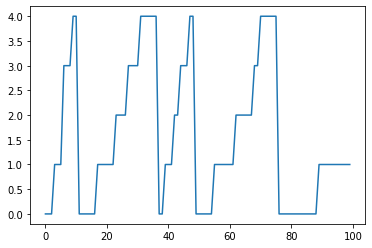

In [558]:
plt.plot(Phase_array[:100])

# regression subspace

- one-hot encode place-phases

- random half-half split of all data from double day

- Lasso regression of place phases onto fr for each neuron

- get place phase x neurons matrix of betas for each split and then stack

- repeat for 50 iterations (get 100 matrices)

- split the big stack in two sw we can do same vs same comparison

- split into phase-specific matrices

- PCA each phase

- project onto subspace plane (first two PCs)

- plot projection

- for each comparison, compute the outer matrix of condition1 subspace vectors against condition2 subspace vectors

- calculate principal angle between planes using singular value decomp on outer matric ( so you get U, S, Vt, take first element of S)




In [559]:
from tqdm import tqdm
one_hot_all = []
for i,j in tqdm(zip(Location_array, Phase_array)):
    one_hot = np.zeros((phase_partitions, max(Location_array.astype(int))))
    one_hot[j,i-1]=1
#     one_hot = np.zeros((max(Location_array.astype(int)),))
#     one_hot[i-1]=1
    one_hot_all.append(one_hot.flatten())
    
one_hot_all = np.array(one_hot_all)

23137it [00:29, 775.61it/s]


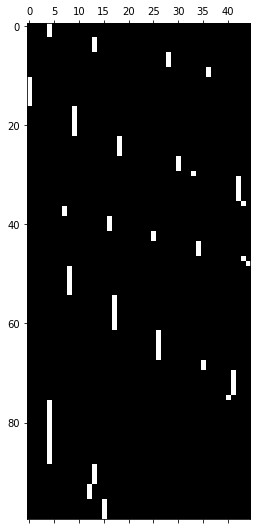

In [560]:
plt.matshow(one_hot_all[:100,:], cmap='gray')

In [561]:
NUM_ITERS = 50
NUM_NEURONS = Neuron_array.shape[0]
NUM_REGRESSORS = np.array(one_hot_all).shape[1]
LASSO_PARAM = 0.00005

for iteration in tqdm(range(NUM_ITERS)):
    
    split_1_mask = np.random.choice([0, 1], size=(len(Location_array),), p=[0.5, 0.5]).astype(bool)
    split_2_mask = ~split_1_mask
    
    betas_array_1 = np.zeros((NUM_NEURONS, NUM_REGRESSORS))
    betas_array_2 = np.zeros((NUM_NEURONS, NUM_REGRESSORS))
    
    for neuron, activity_array in enumerate(Neuron_array):
        
        activity_array_split_1 = activity_array[split_1_mask]
        activity_array_split_2 = activity_array[split_2_mask]
        
        one_hot_all_split_1 = one_hot_all[split_1_mask, :]
        one_hot_all_split_2 = one_hot_all[split_2_mask, :]
        
        lasso_1 = Lasso(alpha = LASSO_PARAM)
        lasso_1.fit(one_hot_all_split_1, activity_array_split_1)
        betas_1 = lasso_1.coef_
        
        lasso_2 = Lasso(alpha = LASSO_PARAM)
        lasso_2.fit(one_hot_all_split_2, activity_array_split_2)
        betas_2 = lasso_2.coef_
        
        betas_array_1[neuron,:]=betas_1
        betas_array_2[neuron,:]=betas_2
        
        
    if iteration==0:
        stacked_betas = np.stack((betas_array_1, betas_array_2))
    else:
        stacked_betas = np.concatenate((stacked_betas, np.expand_dims(betas_array_1, axis=0)), axis=0)
        stacked_betas = np.concatenate((stacked_betas, np.expand_dims(betas_array_2, axis=0)), axis=0)
        
        
num_stacks_in_split = math.floor(stacked_betas.shape[0]/2)

stack_split_1 = stacked_betas[:num_stacks_in_split,:,:]
stack_split_2 = stacked_betas[num_stacks_in_split:,:,:]

mean_betas_1 = np.nanmean(stack_split_1, axis=0)
mean_betas_2 = np.nanmean(stack_split_2, axis=0)


row_means_1 = np.mean(mean_betas_1, axis=1, keepdims=True)
row_means_2 = np.mean(mean_betas_2, axis=1, keepdims=True)

centred_betas_1 = mean_betas_1 - row_means_1
centred_betas_2 = mean_betas_2 - row_means_2
        

100%|██████████| 50/50 [03:02<00:00,  3.65s/it]


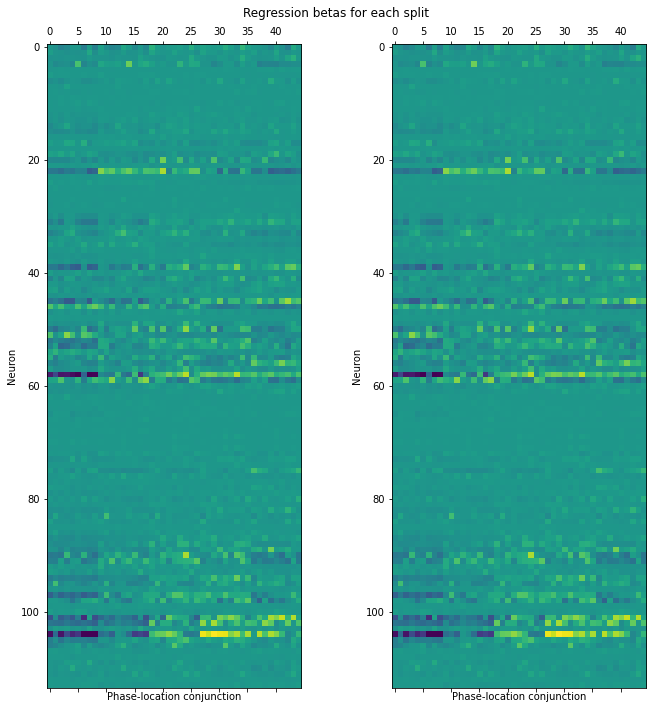

In [562]:

fig, axs = plt.subplots(1,2, figsize = (10,10))
plt.suptitle('Regression betas for each split')

axs[0].matshow(centred_betas_1)
axs[0].set_xlabel('Phase-location conjunction')
axs[0].set_ylabel('Neuron')
axs[1].matshow(centred_betas_2)
axs[1].set_xlabel('Phase-location conjunction')
axs[1].set_ylabel('Neuron')
plt.tight_layout()


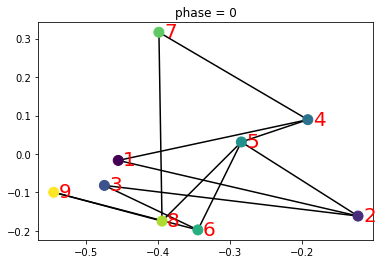

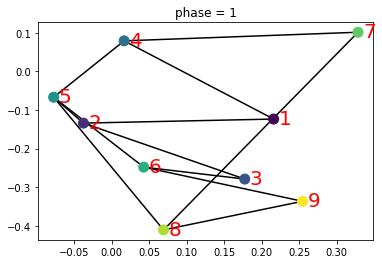

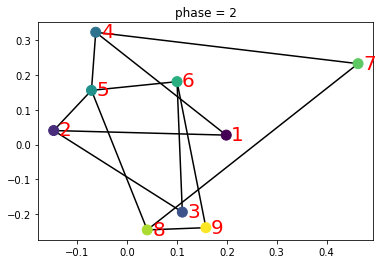

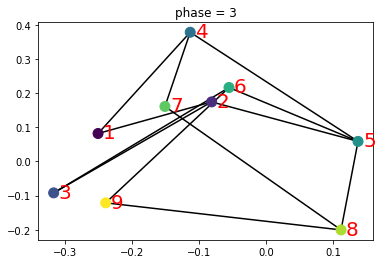

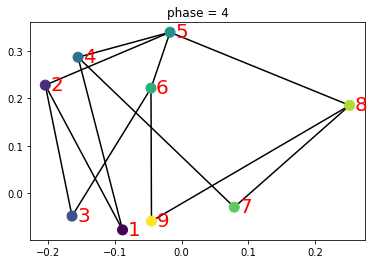

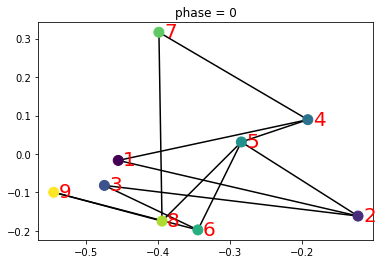

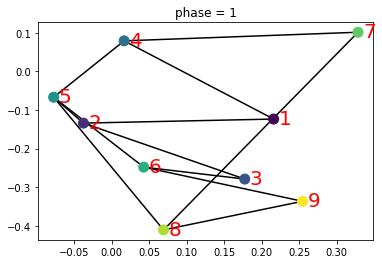

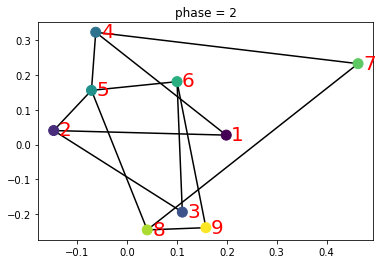

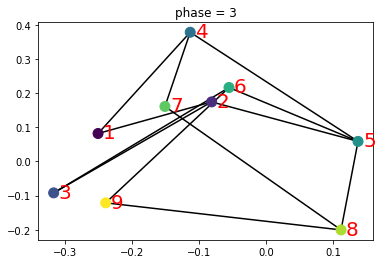

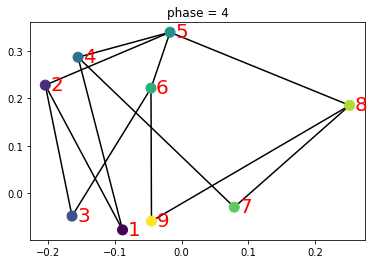

In [566]:
num_locs = max(Location_array)


if phase_partitions==5:
    phase_planes_dic = {
        0:[],
        1:[],
        2:[],
        3:[],
        4:[]
    }
    phase_specific_betas_dic = {
        0:[],
        1:[],
        2:[],
        3:[],
        4:[]
    }

if phase_partitions==3:
    phase_planes_dic = {
        0:[],
        1:[],
        2:[]
    }
    phase_specific_betas_dic = {
        0:[],
        1:[],
        2:[],
    }


centred_betas_dic = {
    0:centred_betas_1,
    1:centred_betas_1
}
for stack in range(2):
    for i in range(phase_partitions):
        ind1 = i * num_locs
        ind2 = i*num_locs+num_locs
        phase_specific_betas = centred_betas_dic[stack][:,ind1:ind2].T
        phase_specific_betas_dic[i].append(phase_specific_betas)
        pca_phase = PCA(n_components=3)
        pca_phase.fit(phase_specific_betas)
        subspace_vectors = pca_phase.components_
        
        phase_planes_dic[i].append(subspace_vectors)
    
        projection = phase_specific_betas.dot(subspace_vectors.T)
#         ax = plt.figure().add_subplot(projection='3d')
#         for connection in connections:
#             y = projection[connection[0],1], projection[connection[1],1]
#             x = projection[connection[0],0], projection[connection[1],0]
#             z = projection[connection[0],2], projection[connection[1],2]
#             ax.plot(y,x,z, color='k')
        
#         ax.scatter(projection[:,1], projection[:,0], projection[:,2], 
#                    c=list(range(len(projection[:,1]))),
#                    s=100, zorder=4)
        
#         node_labels = list(range(1,len(projection[:,1])+1))
                           
# #         for label, x_point, y_point, z_point in zip(node_labels, projection[:,1], projection[:,0]):
# #             ax.annotate(label,
# #                         xy=(x_point, y_point),
# #                         xytext=(5, -5),
# #                         textcoords='offset points',
# #                        zorder=5,
# #                        color='r',
# #                        size=20)

#         ax.set_title(f'phase = {i}')
    
        ax = plt.figure().add_subplot()
        for connection in connections:
            y = projection[connection[0],1], projection[connection[1],1]
            x = projection[connection[0],0], projection[connection[1],0]
           
            ax.plot(y,x, color='k')
        
        ax.scatter(projection[:,1], projection[:,0],
                   c=list(range(len(projection[:,1]))),
                   s=100, zorder=4)
        
        node_labels = list(range(1,len(projection[:,1])+1))
                           
        for label, x_point, y_point in zip(node_labels, projection[:,1], projection[:,0]):
            ax.annotate(label,
                        xy=(x_point, y_point),
                        xytext=(5, -5),
                        textcoords='offset points',
                       zorder=5,
                       color='r',
                       size=20)

        ax.set_title(f'phase = {i}')
        
        
        
    

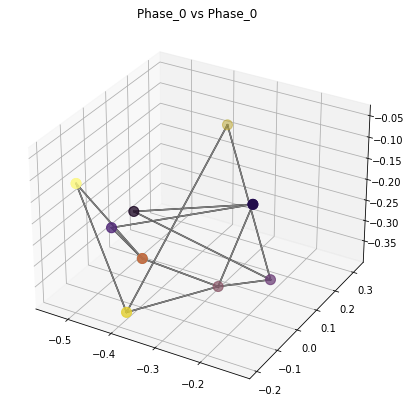

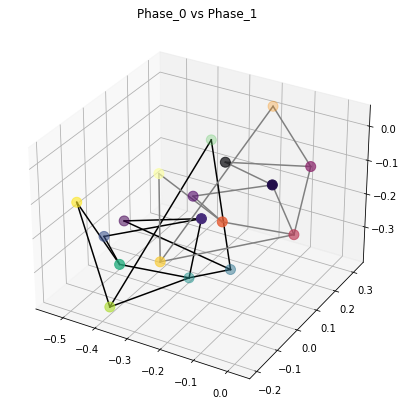

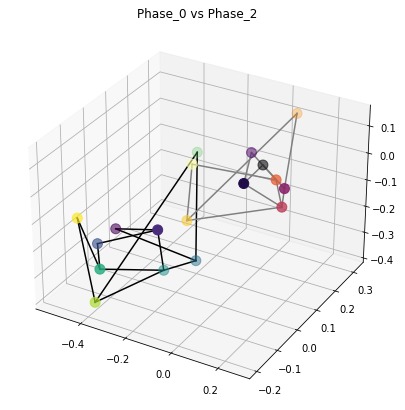

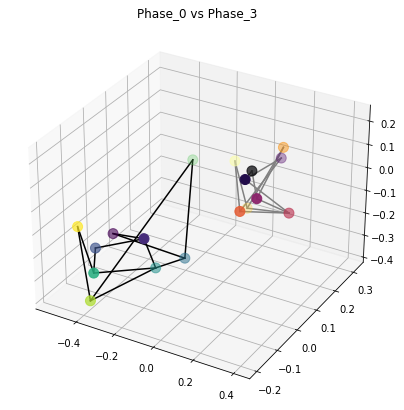

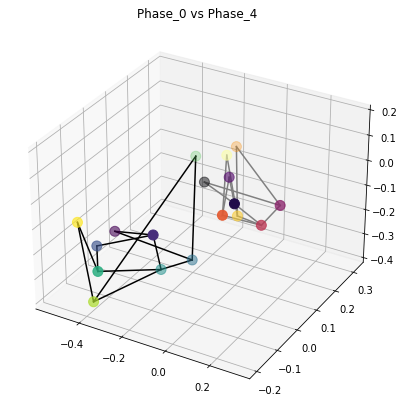

In [509]:
for i in range(0,5):
    
    proj_congruent = phase_specific_betas_dic[0][1]
    proj_incongruent = phase_specific_betas_dic[i][1]
    subspace_vectors = phase_planes_dic[0][1]
    if i==0:
        proj_incongruent = phase_specific_betas_dic[i][0] 
    proj_1 = proj_congruent.dot(subspace_vectors.T)
    proj_2 = proj_incongruent.dot(subspace_vectors.T)

    ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
    ax.set_title(f'Phase_0 vs Phase_{i}')
    for connection in connections:
        y = proj_1[connection[0],1], proj_1[connection[1],1]
        x = proj_1[connection[0],0], proj_1[connection[1],0]
        z = proj_1[connection[0],2], proj_1[connection[1],2]
        ax.plot(y,x,z, color='k')

        y2 = proj_2[connection[0],1], proj_2[connection[1],1]
        x2 = proj_2[connection[0],0], proj_2[connection[1],0]
        z2 = proj_2[connection[0],2], proj_2[connection[1],2]
        ax.plot(y2,x2,z2, color='gray')

    ax.scatter(proj_1[:,1], proj_1[:,0], proj_1[:,2], 
               c=list(range(len(proj_1[:,1]))),
               s=100, zorder=4, cmap = 'viridis')

    ax.scatter(proj_2[:,1], proj_2[:,0], proj_2[:,2], 
               c=list(range(len(proj_2[:,1]))),
               s=100, zorder=4, cmap = 'inferno')
    plt.show()


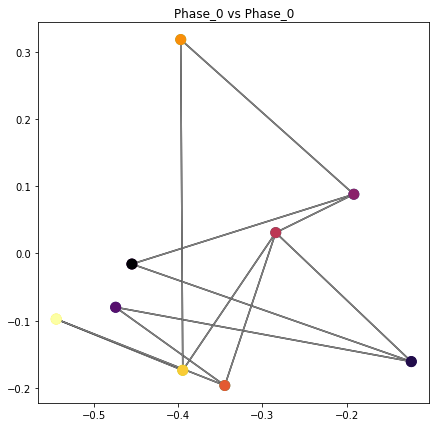

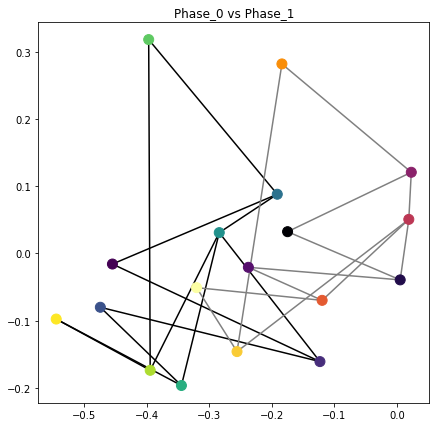

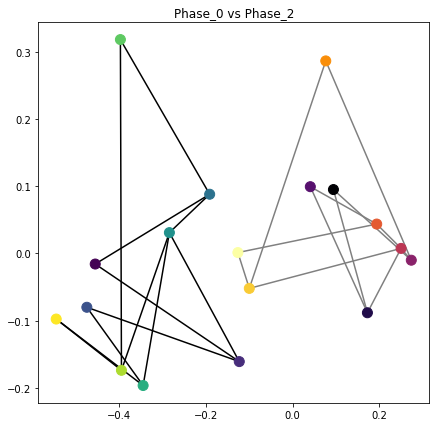

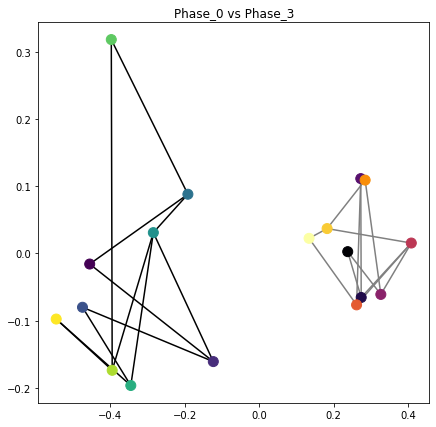

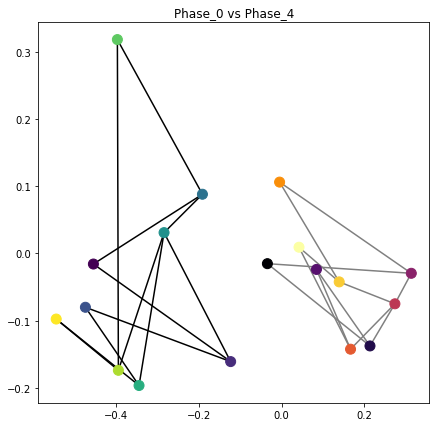

In [514]:
for i in range(0,5):
    
    proj_congruent = phase_specific_betas_dic[0][1]
    proj_incongruent = phase_specific_betas_dic[i][1]
    subspace_vectors = phase_planes_dic[0][1][:2,:]
    if i==0:
        proj_incongruent = phase_specific_betas_dic[i][0] 
    proj_1 = proj_congruent.dot(subspace_vectors.T)
    proj_2 = proj_incongruent.dot(subspace_vectors.T)

    ax = plt.figure(figsize=(7,7)).add_subplot()
    ax.set_title(f'Phase_0 vs Phase_{i}')
    for connection in connections:
        y = proj_1[connection[0],1], proj_1[connection[1],1]
        x = proj_1[connection[0],0], proj_1[connection[1],0]
      
        ax.plot(y,x, color='k')

        y2 = proj_2[connection[0],1], proj_2[connection[1],1]
        x2 = proj_2[connection[0],0], proj_2[connection[1],0]
       
        ax.plot(y2,x2, color='gray')

    ax.scatter(proj_1[:,1], proj_1[:,0], 
               c=list(range(len(proj_1[:,1]))),
               s=100, zorder=4, cmap = 'viridis')

    ax.scatter(proj_2[:,1], proj_2[:,0], 
               c=list(range(len(proj_2[:,1]))),
               s=100, zorder=4, cmap = 'inferno')
    plt.show()

In [480]:
phase_planes_dic[0][0].shape

(3, 114)

In [481]:
#### self_comps  
angles_self = []
for i in phase_planes_dic:
    plane1 = phase_planes_dic[i][0]
    plane2 = phase_planes_dic[i][1]
    outer_product = plane1.dot(plane2.T)
    U, S, Vt = np.linalg.svd(outer_product, full_matrices=True)
    principal_angle = S[0]
    angles_self.append(principal_angle) 
    
angles_across = []

if phase_partitions ==3:
    comps =[[0,1],
            [0,2],
            [1,2]]

if phase_partitions ==5:
    comps =[[0,1],
            [0,2],
            [0,3],
            [0,4],
            [2,4]]

for comp in comps:
    plane1 = phase_planes_dic[comp[0]][0]
    plane2 = phase_planes_dic[comp[1]][1]
    outer_product = plane1.dot(plane2.T)
    U, S, Vt = np.linalg.svd(outer_product, full_matrices=True)
    principal_angle = S[0]
    angles_across.append(principal_angle) 

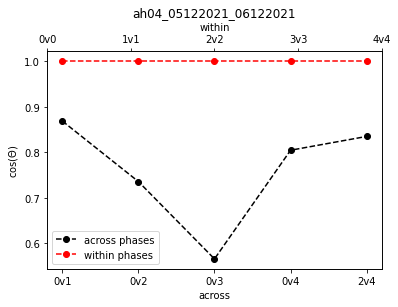

In [483]:
if phase_partitions==5:
    fig, ax = plt.subplots()

    ax.plot(angles_across, linestyle='--', marker='o', color='k', label='across phases')
    ax.plot(angles_self, linestyle='--', marker='o', color='r', label='within phases')
    plt.ylabel(r"$\cos({\Theta})$")
    plt.xlabel('across')
    plt.legend()

    plt.xticks(ticks = [0,1,2, 3, 4], labels=['0v1','0v2','0v3','0v4','2v4'])
    plt.title(mouse_recday)
    ax2 = ax.twiny()

    # Define the positions and labels for the second set of x-ticks
    new_xticks_positions = [0, 1, 2, 3, 4]
    new_xticks_labels = ['0v0', '1v1', '2v2', '3v3', '4v4']

    # Set the positions of the second x-axis ticks
    ax2.set_xticks(new_xticks_positions)

    # Set the labels for the second x-axis ticks
    ax2.set_xticklabels(new_xticks_labels)

    # Set the label for the second x-axis
    ax2.set_xlabel('within')


if phase_partitions ==3:
    fig, ax = plt.subplots()

    ax.plot(angles_across, linestyle='--', marker='o', color='k', label='across phases')
    ax.plot(angles_self, linestyle='--', marker='o', color='r', label='within phases')
    plt.ylabel(r"$\cos({\Theta})$")
    plt.xlabel('across')
    plt.legend()

    plt.xticks(ticks = [0,1,2], labels=['0v1',  '0v2', '1 v 2'])
    plt.title(mouse_recday)
    ax2 = ax.twiny()

    # Define the positions and labels for the second set of x-ticks
    new_xticks_positions = [0, 1, 2]
    new_xticks_labels = ['0v0', '1v1', '2v2']

    # Set the positions of the second x-axis ticks
    ax2.set_xticks(new_xticks_positions)

    # Set the labels for the second x-axis ticks
    ax2.set_xticklabels(new_xticks_labels)

    # Set the label for the second x-axis
    ax2.set_xlabel('within')


In [280]:
x = np.random.choice([0, 1], size=(10,), p=[0.5, 0.5]).astype(bool)
y = ~x

In [281]:
print(x)
print(y)

[ True  True  True False  True False  True  True False False]
[False False False  True False  True False False  True  True]


In [ ]:
# centre the data
Neuron_array=Neuron_array.T
mean_values = np.mean(Neuron_array, axis=0)  # Calculate the mean of each column
centered_data = Neuron_array - mean_values   # Subtract the mean from each column

# Whitening the data
# std_values = np.std(centered_data, axis=0)  # Calculate the standard deviation of each column
# whitened_data = centered_data / std_values   # Divide each column by its standard deviation


In [235]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA



def silhouette_optimization(data, labels=Locations_phase):
    labels = labels
    num_components=data.shape[1]
    """
    Optimize rotation matrix for silhouette score.

    Parameters:
    - data: The input data.
    - num_components: The number of components to use for projection.

    Returns:
    - best_rotation_matrix: The optimized rotation matrix.
    - best_silhouette_score: The highest silhouette score achieved.
    """
    
    def objective_function(rotation_matrix_flat, data, labels=Locations_phase):
        # Reshape the flattened rotation matrix
        rotation_matrix = rotation_matrix_flat.reshape((num_components, 2))

        # Project the data onto the rotated space
        projected_data = data.dot(rotation_matrix)

        # Compute silhouette score
        silhouette_score_value = silhouette_score(projected_data, labels)
        
        # The optimization task is to maximize the silhouette score, so we return the negative value
        return -silhouette_score_value
    

    # Initialize a random rotation matrix
    initial_rotation_matrix = np.random.rand(num_components, 2)
    initial_rotation_matrix, _ = np.linalg.qr(initial_rotation_matrix)

    # Flatten the matrix for optimization
    initial_guess = initial_rotation_matrix.flatten()

    # Perform optimization
    result = minimize(objective_function, initial_guess, args=(data,), method='L-BFGS-B')

    # Reshape the optimized flat rotation matrix to its original shape
    best_rotation_matrix = result.x.reshape((num_components, 2))

    # Project the data onto the rotated space using the best rotation matrix
    projected_data = data.dot(best_rotation_matrix)

    # Compute the silhouette score for the best rotation matrix
    best_silhouette_score = silhouette_score(projected_data, labels)

    return best_rotation_matrix, best_silhouette_score




In [236]:
initial_rotation_matrix = np.random.rand(Neurons_phase.shape[1], 2)
initial_rotation_matrix, _ = np.linalg.qr(initial_rotation_matrix)

In [237]:
xx=Neurons_phase.dot(initial_rotation_matrix)
plt.scatter(XX[:,0], xx[:,1], c=Locations_phase)

SyntaxError: invalid syntax (<ipython-input-237-ba2fb1025042>, line 2)

In [ ]:
plt.scatter(Neurons_phase[:,5], Neurons_phase[:,8], c=Locations_phase)

In [ ]:
mask = Phase_array==0
Phase_phase = Phase_array[mask]
Neurons_phase = centered_data[mask,:]
Locations_phase =Location_array[mask]
# Assuming 'your_data' is a 2D array representing your data
# Make sure your_data.shape[1] > 1, as silhouette score makes sense in at least 2D
best_rotation_matrix, best_silhouette_score = silhouette_optimization(Neurons_phase, Locations_phase)
print("Best Rotation Matrix:")
plt.matshow(best_rotation_matrix)
plt.show()
print("Best Silhouette Score:", best_silhouette_score)

In [ ]:
mask = Phase_array==1
Phase_phase = Phase_array[mask]
Neurons_phase = Neuron_array[mask,:]
Locations_phase =Location_array[mask]
# Assuming 'your_data' is a 2D array representing your data
# Make sure your_data.shape[1] > 1, as silhouette score makes sense in at least 2D
best_rotation_matrix_1, best_silhouette_score_1 = silhouette_optimization(Neurons_phase, Locations_phase)
print("Best Rotation Matrix:")
plt.matshow(best_rotation_matrix_1)
plt.show()
print("Best Silhouette Score:", best_silhouette_score_1)

In [ ]:
mask = Phase_array==2
Phase_phase = Phase_array[mask]
Neurons_phase = Neuron_array[mask,:]
Locations_phase =Location_array[mask]
# Assuming 'your_data' is a 2D array representing your data
# Make sure your_data.shape[1] > 1, as silhouette score makes sense in at least 2D
best_rotation_matrix_2, best_silhouette_score_2 = silhouette_optimization(Neurons_phase, Locations_phase)
print("Best Rotation Matrix:")
plt.matshow(best_rotation_matrix_2)
plt.show()
print("Best Silhouette Score:", best_silhouette_score_2)

In [ ]:
Locations_0v